<a href="https://colab.research.google.com/github/Milad-Khanchi/Image_Classification/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import files
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')
import math
import sys

Import Cifar-10 dataset

In [ ]:
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


In [ ]:
y_train_plot = y_train
y_test_plot  = y_test

Change output to Softmax Classification:

In [ ]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [ ]:
print('Input  Trainset shape: ' ,x_train.shape)
print('Output Trainset shape: ' ,y_train.shape)
print('Input  Testset  shape: ' ,x_test.shape)
print('Output Testset  shape: ' ,y_test.shape)

Input  Trainset shape:  (50000, 32, 32, 3)
Output Trainset shape:  (50000, 10)
Input  Testset  shape:  (10000, 32, 32, 3)
Output Testset  shape:  (10000, 10)


Based on [keras](https://keras.io/api/datasets/cifar10/)

Corresponding classes for the labels: ['frog', 'truck', 'truck', 'deer', 'automobile']
Corresponding classes for the labels: ['cat', 'ship', 'ship', 'airplane', 'frog']


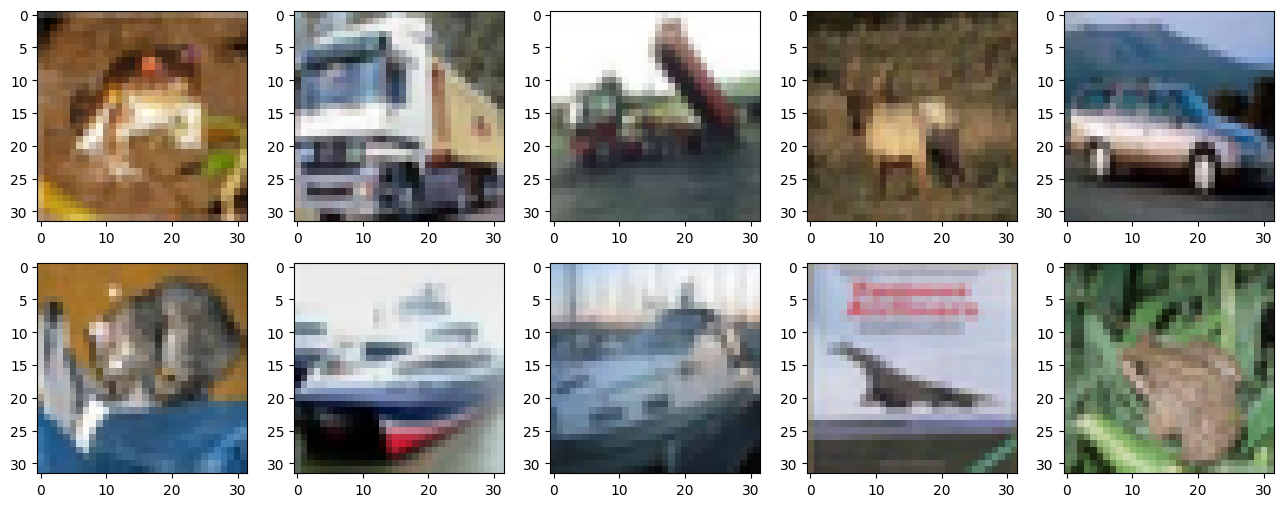

In [ ]:
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print('Corresponding classes for the labels: ' + str([cifar_classes[x[0]] for x in y_train_plot[0:5]]))

f, axarr = plt.subplots(2, 5)
f.set_size_inches(16, 6)

for i in range(5):
    img = x_train[i]
    axarr[0][i].imshow(img)
print('Corresponding classes for the labels: ' + str([cifar_classes[x[0]] for x in y_test_plot[0:5]]))
for i in range(5):
    img = x_test[i]
    axarr[1][i].imshow(img)

plt.show()

Data should be reshaped to one row for each image and then normilized (IMPORTANT)

In [ ]:
x_train = x_train.reshape(50000,3072)
x_test = x_test.reshape(10000,3072)

x_train = x_train / 255
x_test  = x_test  / 255

x_train = x_train - np.mean(x_train, axis = 0)
x_test  = x_test - np.mean(x_test, axis = 0)

x_train = x_train / np.std(x_train, axis = 0)
x_test  = x_test / np.std(x_test, axis = 0)

Plot Normalized Dataset

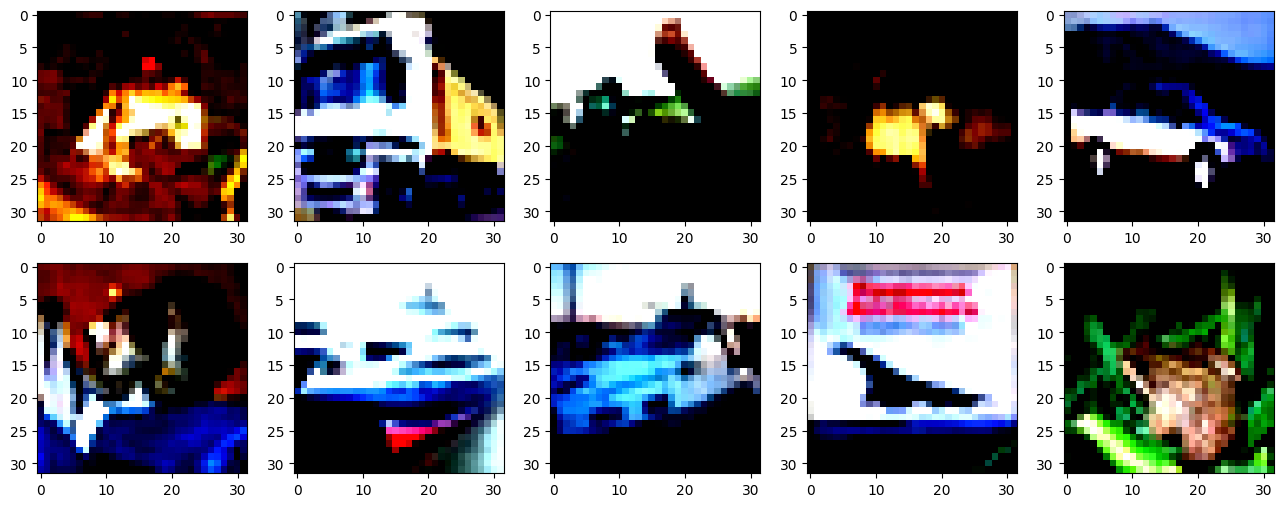

In [ ]:
x_train_plot = x_train.reshape(50000,32,32,3)
x_test_plot = x_test.reshape(10000,32,32,3)

f, axarr = plt.subplots(2, 5)
f.set_size_inches(16, 6)

for i in range(5):
    img = x_train_plot[i]
    axarr[0][i].imshow(img)

for i in range(5):
    img = x_test_plot[i]
    axarr[1][i].imshow(img)

plt.show()

**MLP**

In [ ]:
logistic   = lambda z: 1./ (1 + np.exp(-z))
logistic_d = lambda z: logistic(z) * (1 - logistic(z))

In [ ]:
softmax  = lambda z: np.exp(z - np.max(z,axis=1)[:,None])/np.sum(np.exp(z - np.max(z,axis=1)[:,None]),1)[:,None]

In [ ]:
Relu     = lambda z: np.maximum(0, z)
Relu_d   = lambda z: np.heaviside(z, 0)

In [ ]:
lReLu = lambda z: np.maximum(0, z) + 0.01*np.minimum(0, z)
lReLu_d = lambda z: np.heaviside(z, 0)-0.01*np.heaviside(-z,1)

In [ ]:
tanh = lambda z: (np.exp(z) - np.exp(-z))/(np.exp(z) + np.exp(-z))
tanh_d = lambda z: 1-(tanh(z))**2

In [ ]:
def logsumexp(z):
  zmax = np.max(z,axis=1)[:,None]
  log_sum_exp = zmax + np.log(np.sum(np.exp(z - zmax), axis=1))[:,None]
  return log_sum_exp


SGD model:

In [ ]:
class SGD:

    def __init__(self, learning_rate=.01, max_iters=1e4, epsilon=1e-8, Batch_size = 16, save_error = True, test_loss = True):
        self.batch_size = Batch_size
        self.save_error = save_error
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        self.count = 0
        self.err = []
        self.total_err = []
        self.total_test_err = []
        self.cal_test = False
        self.test_loss = test_loss

    def run(self, gradient_fn, x, y, params):

        B = int(x.shape[0] / self.batch_size)
        #print('x shape: ', x.shape[0], 'B: ', B)
        norms = [np.array([np.inf]), np.array([np.inf])]
        t = 1
        #print(len(params))

        while t < self.max_iters and np.any(norms[0] > self.epsilon) and np.any(norms[1] > self.epsilon):

          x = np.column_stack([x,y])      #shuffle the values of each batch in each iter
          np.random.shuffle(x)
          y = x[:, -10:]
          x = x[:, :-10]

          for b in range(B):
            self.count += 1
            #print(self.count)

            if b == B-1 and self.test_loss:
              self.cal_test = True
            else:
              self.cal_test = False

            grad, er, test_er = gradient_fn(x[b*self.batch_size : (b+1)*self.batch_size, :], y[b*self.batch_size : (b+1)*self.batch_size, :], params, self.cal_test)

            self.err.append(er)

            if self.cal_test:
              self.total_test_err.append(test_er)

            for j in range(len(params)):
              for p in range(len(params[j])):
                  params[j][p] -= self.learning_rate * grad[j][p]

                  norms[j] = np.array([np.linalg.norm(g) for g in grad[j]])

          if self.cal_test:
            print('Epoch:', t, '/ Train error:', round(np.mean(self.err), 2), '/ test error:', round(self.total_test_err[-1], 2))
          else:
            print('Epoch:', t, '/ Train error:', round(np.mean(self.err), 2))

          t += 1

          if self.save_error:
            self.total_err.append(np.mean(self.err))

          self.err = []

          #print(t)
        return params, self.total_err, self.total_test_err


Variable MLP with bias and cross entropy saving:

In [ ]:
class MLP2:

    def __init__(self, M = [64, 64], activation = Relu, C = 10):
        self.M = M
        self.C = C
        self.activation = activation
        if self.activation == Relu:
          self.activation_d = Relu_d
        elif self.activation == logistic:
          self.activation_d = logistic_d
        elif self.activation == lReLu:
          self.activation_d = lReLu_d
        elif self.activation == tanh:
          self.activation_d = tanh_d
        self.count = 0
        self.train_loss = []
        self.test_loss  = []

    def fit(self, x, y, test_set, optimizer):
        x_test, y_test = test_set
        Nt = x.shape[0]
        x = np.column_stack([x,np.ones(Nt)]) #add bias
        Nt = x_test.shape[0]
        x_test = np.column_stack([x_test,np.ones(Nt)]) #add bias
        N,D = x.shape
        w = []
        b = []


        w.append(np.random.randn(D, self.M[0]) * .01)
        #print(w[0].shape)

        for i in range(1, len(self.M)):
          w.append(np.random.randn(self.M[i-1], self.M[i]) * .01)
          b.append(np.random.randn(1, self.M[i]) * 0.01)
          #print(w[i].shape)

        w.append(np.random.randn(self.M[-1], self.C) * .01)
        #print(w[-1].shape)

        params0 = [w, b]

        def gradient(x, y, params, test_cal):
          batch = x.shape[0]
          w, b = params
          dw = []
          db = []
          z  = []
          self.count += 1

          #forward path
          z.append(self.activation(np.dot(x,w[0]))) #N x M[0]
          #print(z[0].shape)

          for i in range(0, len(self.M)-1):
            z.append(self.activation(np.dot(z[i],w[i+1])) + b[i])
            #print(z[i+1].shape) #N x M[i]

          z.append(softmax(np.dot(z[-1], w[-1]))) #N x C
          #print(z[-1].shape)

          #backpropagation
          delta = z[-1] - y #N x C
          dw.append((np.dot(z[-2].T, delta)/batch)) #M[-1] x C
          #print(dw[0].shape)

          for i in range(1, len(self.M)):
            delta = np.dot(delta, w[-i].T) #N x M[i]
            #print(delta.shape)
            db.append((np.dot(np.ones([delta.shape[0], 1]).T, delta))/batch) #1 x M[i]
            #print(db[i-1].shape)
            delta = delta * self.activation_d(z[-(i+1)])
            #print(delta.shape)
            dw.append((np.dot(z[-(i+2)].T, delta))/batch)

          delta = np.dot(delta, w[1].T) * self.activation_d(z[0])
          dw.append((np.dot(x.T, delta))/batch)
          dw.reverse()
          db.reverse()

          dparams = [dw, db]

          #test loss:
          er_test = 0
          if test_cal:
            q  = []

            q.append(self.activation(np.dot(x_test,w[0]))) #N x M[0]
            #print(z[0].shape)

            for i in range(0, len(self.M)-1):
              q.append(self.activation(np.dot(q[i],w[i+1])) + b[i])
              #print(z[i+1].shape) #N x M[i]

            q.append(softmax(np.dot(q[-1], w[-1]))) #N x C
            #print(z[-1].shape)

            er_test = -np.mean(np.sum(np.dot(q[-2], w[-1])*y_test, 1) - logsumexp(np.dot(q[-2], w[-1])))


          er = -np.mean(np.sum(np.dot(z[-2], w[-1])*y, 1) - logsumexp(np.dot(z[-2], w[-1])))

          #print(-np.mean(np.sum(np.dot(z[-2], w[-1])*y, 1) - logsumexp(np.dot(z[-2], w[-1]))))
          #print(self.count)
          #print(dparams)
          return dparams, er, er_test

        self.params, self.train_loss, self.test_loss = optimizer.run(gradient, x, y, params0)
        #print(self.params)

        return self

    def predict(self, x):

        Nt = x.shape[0]
        x = np.column_stack([x,np.ones(Nt)]) #add bias
        w, b = self.params
        z = []

        z.append(self.activation(np.dot(x,w[0])))

        for i in range(1, len(self.M)):
          z.append(self.activation(np.dot(z[i-1], w[i])) + b[i-1])

        z.append(softmax(np.dot(z[-1], w[-1])))

        return z[-1]

    def classify(self, yh):

      Classif = []
      for i in range(0,yh.shape[0]):
        x, y = np.unravel_index(yh[i, :].argmax(axis = 0), yh.shape)
        #print(yh[i, :].argmax(axis = 0), '@', yh[i,:])
        Classif.append([y])
      return Classif

    def print_Train_loss(self):
      return self.train_loss

    def accuracy(self, y, yh):
      return np.mean(yh == y) * 100

    def print_Test_loss(self):
      return self.test_loss


Batch size = 32, learning rate = 0.01

In [ ]:
model = MLP2(M=[256, 256], C=10, activation = Relu)
optimizer = SGD(learning_rate=.01, max_iters=60, Batch_size = 32, save_error = True, test_loss = True)
model.fit(x_train, y_train, [x_test, y_test], optimizer)

Epoch: 1 / Train error: 2.04 / test error: 1.79
Epoch: 2 / Train error: 1.69 / test error: 1.59
Epoch: 3 / Train error: 1.54 / test error: 1.49
Epoch: 4 / Train error: 1.44 / test error: 1.44
Epoch: 5 / Train error: 1.37 / test error: 1.4
Epoch: 6 / Train error: 1.31 / test error: 1.38
Epoch: 7 / Train error: 1.26 / test error: 1.35
Epoch: 8 / Train error: 1.21 / test error: 1.35
Epoch: 9 / Train error: 1.16 / test error: 1.34
Epoch: 10 / Train error: 1.12 / test error: 1.35
Epoch: 11 / Train error: 1.08 / test error: 1.35
Epoch: 12 / Train error: 1.04 / test error: 1.38
Epoch: 13 / Train error: 1.01 / test error: 1.38
Epoch: 14 / Train error: 0.98 / test error: 1.38
Epoch: 15 / Train error: 0.94 / test error: 1.39
Epoch: 16 / Train error: 0.91 / test error: 1.41
Epoch: 17 / Train error: 0.88 / test error: 1.46
Epoch: 18 / Train error: 0.85 / test error: 1.43
Epoch: 19 / Train error: 0.82 / test error: 1.46
Epoch: 20 / Train error: 0.79 / test error: 1.47
Epoch: 21 / Train error: 0.76 

Test:

In [ ]:
yh_predict = model.predict(x_test)

In [ ]:
yh_predict = model.classify(yh_predict)

In [ ]:
model.accuracy(y_test_plot, yh_predict)

40.93

In [ ]:
train_loss_batch32 = model.print_Train_loss()

In [ ]:
test_loss_batch32 = model.print_Test_loss()

Train:

In [ ]:
yh_predict = model.predict(x_train)

In [ ]:
yh_predict = model.classify(yh_predict)

In [ ]:
model.accuracy(y_train_plot, yh_predict)

90.912

Cross entropy error:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

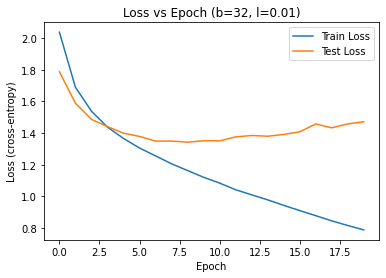

In [ ]:
plt.plot(range(0,20), train_loss_batch32[:20], label='Train Loss')
plt.plot(range(0,20), test_loss_batch32[:20], label='Test Loss')
plt.title('Loss vs Epoch (b=32, l=0.01)')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss (cross-entropy)')
plt.savefig('Loss_Epoch b=32 l=0.01 25 epoch.pdf', format='pdf', bbox_inches='tight')
#files.download('Loss_Epoch b=32 l=0.01 25 epoch.pdf')
plt.show()
# 10 epoch is best

learning rate : 0.001, batch size = 128

In [ ]:
model = MLP2(M=[256, 256], C=10, activation = Relu)
optimizer = SGD(learning_rate=.001, max_iters=100, Batch_size = 128, save_error = True, test_loss = True)
model.fit(x_train, y_train, [x_test, y_test], optimizer)

Epoch: 1 / Train error: 2.3 / test error: 2.3
Epoch: 2 / Train error: 2.3 / test error: 2.3
Epoch: 3 / Train error: 2.3 / test error: 2.3
Epoch: 4 / Train error: 2.3 / test error: 2.3
Epoch: 5 / Train error: 2.29 / test error: 2.29
Epoch: 6 / Train error: 2.29 / test error: 2.29
Epoch: 7 / Train error: 2.28 / test error: 2.28
Epoch: 8 / Train error: 2.28 / test error: 2.27
Epoch: 9 / Train error: 2.26 / test error: 2.25
Epoch: 10 / Train error: 2.24 / test error: 2.23
Epoch: 11 / Train error: 2.22 / test error: 2.2
Epoch: 12 / Train error: 2.19 / test error: 2.18
Epoch: 13 / Train error: 2.16 / test error: 2.15
Epoch: 14 / Train error: 2.13 / test error: 2.12
Epoch: 15 / Train error: 2.11 / test error: 2.09
Epoch: 16 / Train error: 2.08 / test error: 2.07
Epoch: 17 / Train error: 2.06 / test error: 2.05
Epoch: 18 / Train error: 2.04 / test error: 2.03
Epoch: 19 / Train error: 2.02 / test error: 2.01
Epoch: 20 / Train error: 2.01 / test error: 1.99
Epoch: 21 / Train error: 1.99 / test e

Test:

In [ ]:
yh_predict = model.predict(x_test)

In [ ]:
yh_predict = model.classify(yh_predict)

In [ ]:
model.accuracy(y_test_plot, yh_predict)

46.989999999999995

In [ ]:
train_loss_batch64 = model.print_Train_loss()

In [ ]:
test_loss_batch64 = model.print_Test_loss()

Train:

In [ ]:
yh_predict = model.predict(x_train)

In [ ]:
yh_predict = model.classify(yh_predict)

In [ ]:
model.accuracy(y_train_plot, yh_predict)

48.04

Cross entropy error:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

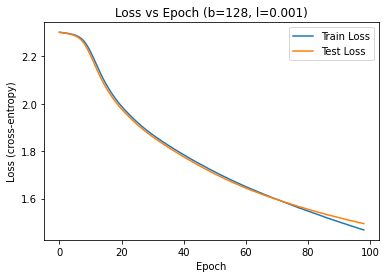

In [ ]:
plt.plot(range(0,99), train_loss_batch64, label='Train Loss')
plt.plot(range(0,99), test_loss_batch64, label='Test Loss')
plt.title('Loss vs Epoch (b=128, l=0.001)')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss (cross-entropy)')
plt.savefig('Loss_Epoch b=128 l=0.001.pdf', format='pdf', bbox_inches='tight')
#files.download('Loss_Epoch b=128 l=0.001.pdf')
plt.show()

accuracies:

In [ ]:
model = MLP2(M=[256, 256], C=10, activation = lReLu)
optimizer = SGD(learning_rate=.01, max_iters=31, Batch_size = 128, save_error = True, test_loss = True)
model.fit(x_train, y_train, [x_test, y_test], optimizer)

Epoch: 1 / Train error: 2.28 / test error: 2.23
Epoch: 2 / Train error: 2.1 / test error: 1.99
Epoch: 3 / Train error: 1.93 / test error: 1.87
Epoch: 4 / Train error: 1.83 / test error: 1.78
Epoch: 5 / Train error: 1.75 / test error: 1.71
Epoch: 6 / Train error: 1.69 / test error: 1.65
Epoch: 7 / Train error: 1.63 / test error: 1.61
Epoch: 8 / Train error: 1.59 / test error: 1.57
Epoch: 9 / Train error: 1.54 / test error: 1.53
Epoch: 10 / Train error: 1.5 / test error: 1.5
Epoch: 11 / Train error: 1.46 / test error: 1.47
Epoch: 12 / Train error: 1.43 / test error: 1.45
Epoch: 13 / Train error: 1.4 / test error: 1.43
Epoch: 14 / Train error: 1.37 / test error: 1.42
Epoch: 15 / Train error: 1.34 / test error: 1.4
Epoch: 16 / Train error: 1.31 / test error: 1.38
Epoch: 17 / Train error: 1.29 / test error: 1.38
Epoch: 18 / Train error: 1.26 / test error: 1.38
Epoch: 19 / Train error: 1.24 / test error: 1.36
Epoch: 20 / Train error: 1.22 / test error: 1.36
Epoch: 21 / Train error: 1.19 / te

Test:

In [ ]:
yh_predict = model.predict(x_test)

In [ ]:
yh_predict = model.classify(yh_predict)

In [ ]:
model.accuracy(y_test_plot, yh_predict)

53.44

In [ ]:
train_loss_batch128 = model.print_Train_loss()

In [ ]:
test_loss_batch128 = model.print_Test_loss()

Train:

In [ ]:
yh_predict = model.predict(x_train)

In [ ]:
yh_predict = model.classify(yh_predict)

In [ ]:
model.accuracy(y_train_plot, yh_predict)

67.16

Cross entropy error:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

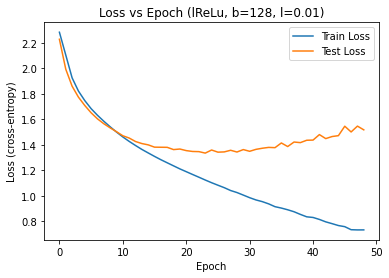

In [ ]:
plt.plot(range(0,49), train_loss_batch128, label='Train Loss')
plt.plot(range(0,49), test_loss_batch128, label='Test Loss')
plt.title('Loss vs Epoch (lReLu, b=128, l=0.01)')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss (cross-entropy)')
plt.savefig('Loss_Epoch lReLu b=128 l=0.01.pdf', format='pdf', bbox_inches='tight')
#files.download('Loss_Epoch lReLu b=128 l=0.01.pdf')
plt.show()

MLP with three hidden layers:

In [ ]:
class MLP2:

    def __init__(self, M = [64, 64], activation = Relu, C = 10):
        self.M = M
        self.C = C
        self.activation = activation
        if self.activation == Relu:
          self.activation_d = Relu_d
        elif self.activation == logistic:
          self.activation_d = logistic_d
        elif self.activation == lReLu:
          self.activation_d = lReLu_d
        elif self.activation == tanh:
          self.activation_d = tanh_d
        self.count = 0
        self.train_loss = []
        self.test_loss  = []

    def fit(self, x, y, test_set, optimizer):
        x_test, y_test = test_set
        Nt = x.shape[0]
        x = np.column_stack([x,np.ones(Nt)]) #add bias
        Nt = x_test.shape[0]
        x_test = np.column_stack([x_test,np.ones(Nt)]) #add bias
        N,D = x.shape
        w = []
        b = []


        w.append(np.random.randn(D, self.M[0]) * .1)
        #print(w[0].shape)

        for i in range(1, len(self.M)):
          w.append(np.random.randn(self.M[i-1], self.M[i]) * .1)
          b.append(np.random.randn(1, self.M[i]) * 0.1)
          #print(w[i].shape)

        w.append(np.random.randn(self.M[-1], self.C) * .1)
        #print(w[-1].shape)

        params0 = [w, b]

        def gradient(x, y, params, test_cal):
          batch = x.shape[0]
          w, b = params
          dw = []
          db = []
          z  = []
          self.count += 1

          #forward path
          z.append(self.activation(np.dot(x,w[0]))) #N x M[0]
          #print(z[0].shape)

          for i in range(0, len(self.M)-1):
            z.append(self.activation(np.dot(z[i],w[i+1])) + b[i])
            #print(z[i+1].shape) #N x M[i]

          z.append(softmax(np.dot(z[-1], w[-1]))) #N x C
          #print(z[-1].shape)

          #backpropagation
          delta = z[-1] - y #N x C
          dw.append((np.dot(z[-2].T, delta)/batch)) #M[-1] x C
          #print(dw[0].shape)

          for i in range(1, len(self.M)):
            delta = np.dot(delta, w[-i].T) #N x M[i]
            #print(delta.shape)
            db.append((np.dot(np.ones([delta.shape[0], 1]).T, delta))/batch) #1 x M[i]
            #print(db[i-1].shape)
            delta = delta * self.activation_d(z[-(i+1)])
            #print(delta.shape)
            dw.append((np.dot(z[-(i+2)].T, delta))/batch)

          delta = np.dot(delta, w[1].T) * self.activation_d(z[0])
          dw.append((np.dot(x.T, delta))/batch)
          dw.reverse()
          db.reverse()

          dparams = [dw, db]

          #test loss:
          er_test = 0
          if test_cal:
            q  = []

            q.append(self.activation(np.dot(x_test,w[0]))) #N x M[0]
            #print(z[0].shape)

            for i in range(0, len(self.M)-1):
              q.append(self.activation(np.dot(q[i],w[i+1])) + b[i])
              #print(z[i+1].shape) #N x M[i]

            q.append(softmax(np.dot(q[-1], w[-1]))) #N x C
            #print(z[-1].shape)

            er_test = -np.mean(np.sum(np.dot(q[-2], w[-1])*y_test, 1) - logsumexp(np.dot(q[-2], w[-1])))


          er = -np.mean(np.sum(np.dot(z[-2], w[-1])*y, 1) - logsumexp(np.dot(z[-2], w[-1])))

          #print(-np.mean(np.sum(np.dot(z[-2], w[-1])*y, 1) - logsumexp(np.dot(z[-2], w[-1]))))
          #print(self.count)
          #print(dparams)
          return dparams, er, er_test

        self.params, self.train_loss, self.test_loss = optimizer.run(gradient, x, y, params0)
        #print(self.params)

        return self

    def predict(self, x):

        Nt = x.shape[0]
        x = np.column_stack([x,np.ones(Nt)]) #add bias
        w, b = self.params
        z = []

        z.append(self.activation(np.dot(x,w[0])))

        for i in range(1, len(self.M)):
          z.append(self.activation(np.dot(z[i-1], w[i])) + b[i-1])

        z.append(softmax(np.dot(z[-1], w[-1])))

        return z[-1]

    def classify(self, yh):

      Classif = []
      for i in range(0,yh.shape[0]):
        x, y = np.unravel_index(yh[i, :].argmax(axis = 0), yh.shape)
        #print(yh[i, :].argmax(axis = 0), '@', yh[i,:])
        Classif.append([y])
      return Classif

    def print_Train_loss(self):
      return self.train_loss

    def accuracy(self, y, yh):
      return np.mean(yh == y) * 100

    def print_Test_loss(self):
      return self.test_loss


In [ ]:
model = MLP2(M=[256, 256, 256], C=10, activation = Relu)
optimizer = SGD(learning_rate=.01, max_iters=100, Batch_size = 128, save_error = True, test_loss = True)
model.fit(x_train, y_train, [x_test, y_test], optimizer)

Epoch: 1 / Train error: 2.59 / test error: 1.93
Epoch: 2 / Train error: 1.8 / test error: 1.75
Epoch: 3 / Train error: 1.65 / test error: 1.67
Epoch: 4 / Train error: 1.57 / test error: 1.61
Epoch: 5 / Train error: 1.51 / test error: 1.59
Epoch: 6 / Train error: 1.46 / test error: 1.56
Epoch: 7 / Train error: 1.42 / test error: 1.54
Epoch: 8 / Train error: 1.39 / test error: 1.52
Epoch: 9 / Train error: 1.36 / test error: 1.51
Epoch: 10 / Train error: 1.33 / test error: 1.5
Epoch: 11 / Train error: 1.3 / test error: 1.5
Epoch: 12 / Train error: 1.28 / test error: 1.49
Epoch: 13 / Train error: 1.25 / test error: 1.49
Epoch: 14 / Train error: 1.23 / test error: 1.49
Epoch: 15 / Train error: 1.21 / test error: 1.5
Epoch: 16 / Train error: 1.19 / test error: 1.48
Epoch: 17 / Train error: 1.16 / test error: 1.49
Epoch: 18 / Train error: 1.14 / test error: 1.5
Epoch: 19 / Train error: 1.12 / test error: 1.5
Epoch: 20 / Train error: 1.1 / test error: 1.52
Epoch: 21 / Train error: 1.08 / test 

Test:

In [ ]:
yh_predict = model.predict(x_test)

In [ ]:
yh_predict = model.classify(yh_predict)

In [ ]:
model.accuracy(y_test_plot, yh_predict)

50.370000000000005

In [ ]:
train_loss_batch128 = model.print_Train_loss()

In [ ]:
test_loss_batch128 = model.print_Test_loss()

Train:

In [ ]:
yh_predict = model.predict(x_train)

In [ ]:
yh_predict = model.classify(yh_predict)

In [ ]:
model.accuracy(y_train_plot, yh_predict)

62.676

Cross entropy error:

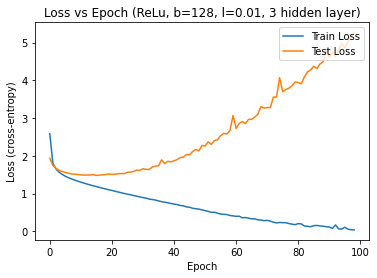

In [ ]:
plt.plot(range(0,99), train_loss_batch128, label='Train Loss')
plt.plot(range(0,99), test_loss_batch128, label='Test Loss')
plt.title('Loss vs Epoch (ReLu, b=128, l=0.01, 3 hidden layer)')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss (cross-entropy)')
plt.savefig('Loss_Epoch lReLu b=128 l=0.01.pdf', format='pdf', bbox_inches='tight')
#files.download('Loss_Epoch lReLu b=128 l=0.01.pdf')
plt.show()

MLP without hidden layer:

In [ ]:
class MLP:

    def __init__(self, activation = Relu, C = 10):
        self.C = C
        self.activation = activation
        if self.activation == Relu:
          self.activation_d = Relu_d
        elif self.activation == logistic:
          self.activation_d = logistic_d
        elif self.activation == lReLu:
          self.activation_d = lReLu_d
        elif self.activation == tanh:
          self.activation_d = tanh_d
        self.count = 0
        self.train_loss = []
        self.test_loss  = []

    def fit(self, x, y, test_set, optimizer):
        x_test, y_test = test_set
        Nt = x.shape[0]
        x = np.column_stack([x,np.ones(Nt)]) #add bias
        Nt = x_test.shape[0]
        x_test = np.column_stack([x_test,np.ones(Nt)]) #add bias
        N,D = x.shape
        w = []
        b = []

        w.append(np.random.randn(D, self.C) * .01)
        #print(w[-1].shape)

        params0 = [w, b]

        def gradient(x, y, params, test_cal):
          batch = x.shape[0]
          w, b = params
          dw = []
          db = []
          z  = []
          self.count += 1

          #forward path
          z.append(softmax(np.dot(x, w[-1]))) #N x C
          #print(z[-1].shape)

          #backpropagation
          delta = z[-1] - y #N x C
          dw.append((np.dot(x.T, delta))/batch)

          dparams = [dw, db]

          #test loss:
          er_test = 0
          if test_cal:
            q  = []
            q.append(softmax(np.dot(x_test, w[-1]))) #N x C
            #print(z[-1].shape)

            er_test = -np.mean(np.sum(np.dot(x_test, w[-1])*y_test, 1) - logsumexp(np.dot(x_test, w[-1])))


          er = -np.mean(np.sum(np.dot(x, w[-1])*y, 1) - logsumexp(np.dot(x, w[-1])))

          #print(-np.mean(np.sum(np.dot(z[-2], w[-1])*y, 1) - logsumexp(np.dot(z[-2], w[-1]))))
          #print(self.count)
          #print(dparams)
          return dparams, er, er_test

        self.params, self.train_loss, self.test_loss = optimizer.run(gradient, x, y, params0)
        #print(self.params)

        return self

    def predict(self, x):

        Nt = x.shape[0]
        x = np.column_stack([x,np.ones(Nt)]) #add bias
        w, b = self.params
        z = []

        z.append(softmax(np.dot(x, w[-1])))

        return z[-1]

    def classify(self, yh):

      Classif = []
      for i in range(0,yh.shape[0]):
        x, y = np.unravel_index(yh[i, :].argmax(axis = 0), yh.shape)
        #print(yh[i, :].argmax(axis = 0), '@', yh[i,:])
        Classif.append([y])
      return Classif

    def print_Train_loss(self):
      return self.train_loss

    def accuracy(self, y, yh):
      return np.mean(yh == y) * 100

    def print_Test_loss(self):
      return self.test_loss


In [ ]:
model = MLP(C=10, activation = Relu)
optimizer = SGD(learning_rate=.01, max_iters=100, Batch_size = 128, save_error = True, test_loss = True)
model.fit(x_train, y_train, [x_test, y_test], optimizer)

Epoch: 1 / Train error: 1.84 / test error: 1.79
Epoch: 2 / Train error: 1.76 / test error: 1.74
Epoch: 3 / Train error: 1.73 / test error: 1.76
Epoch: 4 / Train error: 1.72 / test error: 1.75
Epoch: 5 / Train error: 1.71 / test error: 1.74
Epoch: 6 / Train error: 1.7 / test error: 1.74
Epoch: 7 / Train error: 1.69 / test error: 1.75
Epoch: 8 / Train error: 1.69 / test error: 1.75
Epoch: 9 / Train error: 1.68 / test error: 1.76
Epoch: 10 / Train error: 1.68 / test error: 1.76
Epoch: 11 / Train error: 1.68 / test error: 1.75
Epoch: 12 / Train error: 1.67 / test error: 1.74
Epoch: 13 / Train error: 1.67 / test error: 1.76
Epoch: 14 / Train error: 1.67 / test error: 1.74
Epoch: 15 / Train error: 1.67 / test error: 1.74
Epoch: 16 / Train error: 1.66 / test error: 1.75
Epoch: 17 / Train error: 1.66 / test error: 1.74
Epoch: 18 / Train error: 1.66 / test error: 1.74
Epoch: 19 / Train error: 1.66 / test error: 1.74
Epoch: 20 / Train error: 1.65 / test error: 1.76
Epoch: 21 / Train error: 1.65 

Test:

In [ ]:
yh_predict = model.predict(x_test)

In [ ]:
yh_predict = model.classify(yh_predict)

In [ ]:
model.accuracy(y_test_plot, yh_predict)

39.67

In [ ]:
train_loss_batch64 = model.print_Train_loss()

In [ ]:
test_loss_batch64 = model.print_Test_loss()

Train:

In [ ]:
yh_predict = model.predict(x_train)

In [ ]:
yh_predict = model.classify(yh_predict)

In [ ]:
model.accuracy(y_train_plot, yh_predict)

42.58

Cross entropy error:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

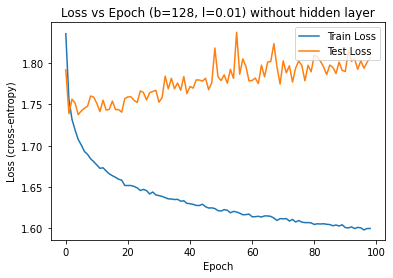

In [ ]:
plt.plot(range(0,99), train_loss_batch64, label='Train Loss')
plt.plot(range(0,99), test_loss_batch64, label='Test Loss')
plt.title('Loss vs Epoch (b=128, l=0.01) without hidden layer')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss (cross-entropy)')
plt.savefig('Loss_Epoch b=128 l=0.01 without hidden layer.pdf', format='pdf', bbox_inches='tight')
#files.download('Loss_Epoch b=128 l=0.01 without hidden layer.pdf')
plt.show()

MLP with one hidden layer:

In [ ]:
model = MLP2(M=[256], C=10, activation = Relu)
optimizer = SGD(learning_rate=.01, max_iters=100, Batch_size = 128, save_error = True, test_loss = True)
model.fit(x_train, y_train, [x_test, y_test], optimizer)

Epoch: 1 / Train error: 1.98 / test error: 1.8
Epoch: 2 / Train error: 1.73 / test error: 1.67
Epoch: 3 / Train error: 1.63 / test error: 1.6
Epoch: 4 / Train error: 1.57 / test error: 1.55
Epoch: 5 / Train error: 1.52 / test error: 1.52
Epoch: 6 / Train error: 1.48 / test error: 1.49
Epoch: 7 / Train error: 1.44 / test error: 1.46
Epoch: 8 / Train error: 1.41 / test error: 1.44
Epoch: 9 / Train error: 1.38 / test error: 1.43
Epoch: 10 / Train error: 1.35 / test error: 1.41
Epoch: 11 / Train error: 1.33 / test error: 1.4
Epoch: 12 / Train error: 1.3 / test error: 1.39
Epoch: 13 / Train error: 1.28 / test error: 1.38
Epoch: 14 / Train error: 1.26 / test error: 1.37
Epoch: 15 / Train error: 1.24 / test error: 1.36
Epoch: 16 / Train error: 1.22 / test error: 1.36
Epoch: 17 / Train error: 1.2 / test error: 1.36
Epoch: 18 / Train error: 1.18 / test error: 1.35
Epoch: 19 / Train error: 1.16 / test error: 1.35
Epoch: 20 / Train error: 1.14 / test error: 1.33
Epoch: 21 / Train error: 1.13 / te

Test:

In [ ]:
yh_predict = model.predict(x_test)

In [ ]:
yh_predict = model.classify(yh_predict)

In [ ]:
model.accuracy(y_test_plot, yh_predict)

53.15

In [ ]:
train_loss_batch64 = model.print_Train_loss()

In [ ]:
test_loss_batch64 = model.print_Test_loss()

Train:

In [ ]:
yh_predict = model.predict(x_train)

In [ ]:
yh_predict = model.classify(yh_predict)

In [ ]:
model.accuracy(y_train_plot, yh_predict)

62.907999999999994

Cross entropy error:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

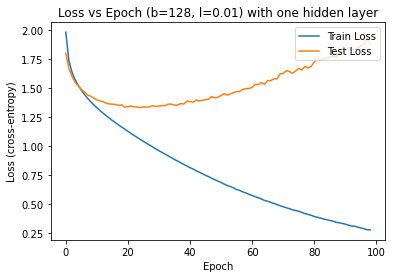

In [ ]:
plt.plot(range(0,99), train_loss_batch64, label='Train Loss')
plt.plot(range(0,99), test_loss_batch64, label='Test Loss')
plt.title('Loss vs Epoch (b=128, l=0.01) with one hidden layer')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss (cross-entropy)')
plt.savefig('Loss_Epoch b=128 l=0.01 with one hidden layer.pdf', format='pdf', bbox_inches='tight')
#files.download('Loss_Epoch b=128 l=0.01 with one hidden layer.pdf')
plt.show()

MLP with unnormalized data:

In [ ]:
model = MLP2(M=[256, 256], C=10, activation = Relu)
optimizer = SGD(learning_rate=.001, max_iters=100, Batch_size = 128, save_error = True, test_loss = True)
model.fit(x_train, y_train, [x_test, y_test], optimizer)

Epoch: 1 / Train error: 1.91 / test error: 1.74
Epoch: 2 / Train error: 1.74 / test error: 1.68
Epoch: 3 / Train error: 1.66 / test error: 1.65
Epoch: 4 / Train error: 1.61 / test error: 1.57
Epoch: 5 / Train error: 1.57 / test error: 1.55
Epoch: 6 / Train error: 1.54 / test error: 1.54
Epoch: 7 / Train error: 1.51 / test error: 1.5
Epoch: 8 / Train error: 1.48 / test error: 1.5
Epoch: 9 / Train error: 1.46 / test error: 1.52
Epoch: 10 / Train error: 1.43 / test error: 1.48
Epoch: 11 / Train error: 1.41 / test error: 1.43
Epoch: 12 / Train error: 1.4 / test error: 1.44
Epoch: 13 / Train error: 1.38 / test error: 1.43
Epoch: 14 / Train error: 1.36 / test error: 1.41
Epoch: 15 / Train error: 1.35 / test error: 1.44
Epoch: 16 / Train error: 1.33 / test error: 1.45
Epoch: 17 / Train error: 1.31 / test error: 1.42
Epoch: 18 / Train error: 1.3 / test error: 1.39
Epoch: 19 / Train error: 1.28 / test error: 1.43
Epoch: 20 / Train error: 1.27 / test error: 1.42
Epoch: 21 / Train error: 1.25 / t

Test:

In [ ]:
yh_predict = model.predict(x_test)

In [ ]:
yh_predict = model.classify(yh_predict)

In [ ]:
model.accuracy(y_test_plot, yh_predict)

51.89

In [ ]:
train_loss_batch64 = model.print_Train_loss()

In [ ]:
test_loss_batch64 = model.print_Test_loss()

Train:

In [ ]:
yh_predict = model.predict(x_train)

In [ ]:
yh_predict = model.classify(yh_predict)

In [ ]:
model.accuracy(y_train_plot, yh_predict)

61.99400000000001

Cross entropy error:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

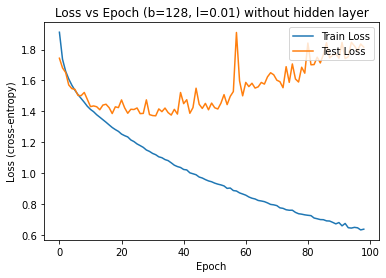

In [ ]:
plt.plot(range(0,99), train_loss_batch64, label='Train Loss')
plt.plot(range(0,99), test_loss_batch64, label='Test Loss')
plt.title('Loss vs Epoch (b=128, l=0.01) without hidden layer')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss (cross-entropy)')
plt.savefig('Loss_Epoch b=128 l=0.01 without hidden layer.pdf', format='pdf', bbox_inches='tight')
#files.download('Loss_Epoch b=128 l=0.01 without hidden layer.pdf')
plt.show()

L1 Regularization:

SGD model:

In [ ]:
class SGDL1:

    def __init__(self, learning_rate=.01, max_iters=1e4, epsilon=1e-8, Batch_size = 16, save_error = True, test_loss = True, lambdaa = 0.1):
        self.batch_size = Batch_size
        self.save_error = save_error
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        self.count = 0
        self.err = []
        self.total_err = []
        self.total_test_err = []
        self.cal_test = False
        self.test_loss = test_loss
        self.lambdaa =lambdaa

    def run(self, gradient_fn, x, y, params):

        B = int(x.shape[0] / self.batch_size)
        #print('x shape: ', x.shape[0], 'B: ', B)
        norms = [np.array([np.inf]), np.array([np.inf])]
        t = 1
        #print(len(params))

        while t < self.max_iters and np.any(norms[0] > self.epsilon) and np.any(norms[1] > self.epsilon):

          x = np.column_stack([x,y])      #shuffle the values of each batch in each iter
          np.random.shuffle(x)
          y = x[:, -10:]
          x = x[:, :-10]

          for b in range(B):
            self.count += 1
            #print(self.count)

            if b == B-1 and self.test_loss:
              self.cal_test = True
            else:
              self.cal_test = False

            grad, er, test_er = gradient_fn(x[b*self.batch_size : (b+1)*self.batch_size, :], y[b*self.batch_size : (b+1)*self.batch_size, :], params, self.cal_test)

            self.err.append(er)

            if self.cal_test:
              self.total_test_err.append(test_er)

            for j in range(len(params)):
              for p in range(len(params[j])):

                  grad[j][p]   += self.lambdaa * np.sign(params[j][p])
                  params[j][p] -= self.learning_rate * grad[j][p]

                  norms[j] = np.array([np.linalg.norm(g) for g in grad[j]])

          if self.cal_test:
            print('Epoch:', t, '/ Train error:', round(np.mean(self.err), 2), '/ test error:', round(self.total_test_err[-1], 2))
          else:
            print('Epoch:', t, '/ Train error:', round(np.mean(self.err), 2))

          t += 1

          if self.save_error:
            self.total_err.append(np.mean(self.err))

          self.err = []

          #print(t)
        return params, self.total_err, self.total_test_err


L1 with lambdaa = 0.01:

In [ ]:
model = MLP2(M=[256, 256], C=10, activation = Relu)
optimizer = SGDL1(learning_rate=.01, max_iters=30, Batch_size = 128, save_error = True, test_loss = True, lambdaa = 0.01)
model.fit(x_train, y_train, [x_test, y_test], optimizer)

Epoch: 1 / Train error: 2.3 / test error: 2.3
Epoch: 2 / Train error: 2.3 / test error: 2.3
Epoch: 3 / Train error: 2.3 / test error: 2.3
Epoch: 4 / Train error: 2.3 / test error: 2.3
Epoch: 5 / Train error: 2.3 / test error: 2.3
Epoch: 6 / Train error: 2.3 / test error: 2.3
Epoch: 7 / Train error: 2.3 / test error: 2.3
Epoch: 8 / Train error: 2.3 / test error: 2.3
Epoch: 9 / Train error: 2.3 / test error: 2.3
Epoch: 10 / Train error: 2.3 / test error: 2.3
Epoch: 11 / Train error: 2.3 / test error: 2.3
Epoch: 12 / Train error: 2.3 / test error: 2.3
Epoch: 13 / Train error: 2.3 / test error: 2.3
Epoch: 14 / Train error: 2.3 / test error: 2.3
Epoch: 15 / Train error: 2.3 / test error: 2.3
Epoch: 16 / Train error: 2.3 / test error: 2.3
Epoch: 17 / Train error: 2.3 / test error: 2.3
Epoch: 18 / Train error: 2.3 / test error: 2.3
Epoch: 19 / Train error: 2.3 / test error: 2.3
Epoch: 20 / Train error: 2.3 / test error: 2.3
Epoch: 21 / Train error: 2.3 / test error: 2.3
Epoch: 22 / Train erro

Test:

In [ ]:
yh_predict = model.predict(x_test)

In [ ]:
yh_predict = model.classify(yh_predict)

In [ ]:
model.accuracy(y_test_plot, yh_predict)

10.0

In [ ]:
train_loss_batch128 = model.print_Train_loss()

In [ ]:
test_loss_batch128 = model.print_Test_loss()

Train:

In [ ]:
yh_predict = model.predict(x_train)

In [ ]:
yh_predict = model.classify(yh_predict)

In [ ]:
model.accuracy(y_train_plot, yh_predict)

10.0

Cross entropy error:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

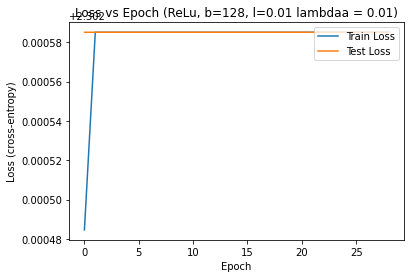

In [ ]:
plt.plot(range(0,29), train_loss_batch128, label='Train Loss')
plt.plot(range(0,29), test_loss_batch128, label='Test Loss')
plt.title('Loss vs Epoch (ReLu, b=128, l=0.01 lambdaa = 0.01)')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss (cross-entropy)')
plt.savefig('ReLu, b=128, l=0.01 lambdaa = 0.01.pdf', format='pdf', bbox_inches='tight')
#files.download('ReLu, b=128, l=0.01 lambdaa = 0.01.pdf')
plt.show()

L1 with lambdaa = 0.001:

In [ ]:
model = MLP2(M=[256, 256], C=10, activation = Relu)
optimizer = SGDL1(learning_rate=.01, max_iters=300, Batch_size = 128, save_error = True, test_loss = True, lambdaa = 0.001)
model.fit(x_train, y_train, [x_test, y_test], optimizer)

Epoch: 1 / Train error: 2.3 / test error: 2.29
Epoch: 2 / Train error: 2.26 / test error: 2.22
Epoch: 3 / Train error: 2.2 / test error: 2.18
Epoch: 4 / Train error: 2.16 / test error: 2.15
Epoch: 5 / Train error: 2.13 / test error: 2.11
Epoch: 6 / Train error: 2.08 / test error: 2.04
Epoch: 7 / Train error: 2.01 / test error: 1.98
Epoch: 8 / Train error: 1.97 / test error: 1.96
Epoch: 9 / Train error: 1.95 / test error: 1.94
Epoch: 10 / Train error: 1.94 / test error: 1.93
Epoch: 11 / Train error: 1.93 / test error: 1.92
Epoch: 12 / Train error: 1.92 / test error: 1.91
Epoch: 13 / Train error: 1.9 / test error: 1.89
Epoch: 14 / Train error: 1.89 / test error: 1.88
Epoch: 15 / Train error: 1.88 / test error: 1.87
Epoch: 16 / Train error: 1.87 / test error: 1.87
Epoch: 17 / Train error: 1.86 / test error: 1.85
Epoch: 18 / Train error: 1.85 / test error: 1.84
Epoch: 19 / Train error: 1.84 / test error: 1.83
Epoch: 20 / Train error: 1.82 / test error: 1.82
Epoch: 21 / Train error: 1.82 / 

Test:

In [ ]:
yh_predict = model.predict(x_test)

In [ ]:
yh_predict = model.classify(yh_predict)

In [ ]:
model.accuracy(y_test_plot, yh_predict)

38.11

In [ ]:
train_loss_batch128 = model.print_Train_loss()

In [ ]:
test_loss_batch128 = model.print_Test_loss()

Train:

In [ ]:
yh_predict = model.predict(x_train)

In [ ]:
yh_predict = model.classify(yh_predict)

In [ ]:
model.accuracy(y_train_plot, yh_predict)

39.464

Cross entropy error:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

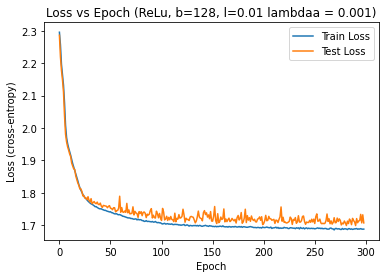

In [ ]:
plt.plot(range(0,299), train_loss_batch128, label='Train Loss')
plt.plot(range(0,299), test_loss_batch128, label='Test Loss')
plt.title('Loss vs Epoch (ReLu, b=128, l=0.01 lambdaa = 0.001)')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss (cross-entropy)')
plt.savefig('ReLu, b=128, l=0.01 lambdaa = 0.001.pdf', format='pdf', bbox_inches='tight')
files.download('ReLu, b=128, l=0.01 lambdaa = 0.001.pdf')
plt.show()

L1 with lambdaa = 0.0001:

In [ ]:
model = MLP2(M=[256, 256], C=10, activation = Relu)
optimizer = SGDL1(learning_rate=.01, max_iters=150, Batch_size = 128, save_error = True, test_loss = True, lambdaa = 0.0001)
model.fit(x_train, y_train, [x_test, y_test], optimizer)

Epoch: 1 / Train error: 2.29 / test error: 2.24
Epoch: 2 / Train error: 2.13 / test error: 2.02
Epoch: 3 / Train error: 1.96 / test error: 1.9
Epoch: 4 / Train error: 1.86 / test error: 1.81
Epoch: 5 / Train error: 1.78 / test error: 1.74
Epoch: 6 / Train error: 1.72 / test error: 1.68
Epoch: 7 / Train error: 1.67 / test error: 1.64
Epoch: 8 / Train error: 1.62 / test error: 1.6
Epoch: 9 / Train error: 1.58 / test error: 1.56
Epoch: 10 / Train error: 1.54 / test error: 1.53
Epoch: 11 / Train error: 1.51 / test error: 1.5
Epoch: 12 / Train error: 1.47 / test error: 1.48
Epoch: 13 / Train error: 1.44 / test error: 1.46
Epoch: 14 / Train error: 1.41 / test error: 1.44
Epoch: 15 / Train error: 1.39 / test error: 1.43
Epoch: 16 / Train error: 1.37 / test error: 1.42
Epoch: 17 / Train error: 1.34 / test error: 1.4
Epoch: 18 / Train error: 1.32 / test error: 1.39
Epoch: 19 / Train error: 1.31 / test error: 1.38
Epoch: 20 / Train error: 1.29 / test error: 1.37
Epoch: 21 / Train error: 1.27 / t

Test:

In [ ]:
yh_predict = model.predict(x_test)

In [ ]:
yh_predict = model.classify(yh_predict)

In [ ]:
model.accuracy(y_test_plot, yh_predict)

52.59

In [ ]:
train_loss_batch128 = model.print_Train_loss()

In [ ]:
test_loss_batch128 = model.print_Test_loss()

In [ ]:
yh_predict = model.predict(x_train)

In [ ]:
yh_predict = model.classify(yh_predict)

In [ ]:
model.accuracy(y_train_plot, yh_predict)

59.864

Cross entropy error:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

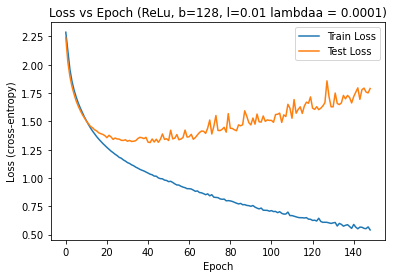

In [ ]:
plt.plot(range(0,149), train_loss_batch128, label='Train Loss')
plt.plot(range(0,149), test_loss_batch128, label='Test Loss')
plt.title('Loss vs Epoch (ReLu, b=128, l=0.01 lambdaa = 0.0001)')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss (cross-entropy)')
plt.savefig('ReLu, b=128, l=0.01 lambdaa = 0.0001.pdf', format='pdf', bbox_inches='tight')
#files.download('ReLu, b=128, l=0.01 lambdaa = 0.0001.pdf')
plt.show()

L2 Regularization:

SGD model:

In [ ]:
class SGDL2:

    def __init__(self, learning_rate=.01, max_iters=1e4, epsilon=1e-8, Batch_size = 16, save_error = True, test_loss = True, lambdaa = 0.1):
        self.batch_size = Batch_size
        self.save_error = save_error
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        self.count = 0
        self.err = []
        self.total_err = []
        self.total_test_err = []
        self.cal_test = False
        self.test_loss = test_loss
        self.lambdaa =lambdaa

    def run(self, gradient_fn, x, y, params):

        B = int(x.shape[0] / self.batch_size)
        #print('x shape: ', x.shape[0], 'B: ', B)
        norms = [np.array([np.inf]), np.array([np.inf])]
        t = 1
        #print(len(params))

        while t < self.max_iters and np.any(norms[0] > self.epsilon) and np.any(norms[1] > self.epsilon):

          x = np.column_stack([x,y])      #shuffle the values of each batch in each iter
          np.random.shuffle(x)
          y = x[:, -10:]
          x = x[:, :-10]

          for b in range(B):
            self.count += 1
            #print(self.count)

            if b == B-1 and self.test_loss:
              self.cal_test = True
            else:
              self.cal_test = False

            grad, er, test_er = gradient_fn(x[b*self.batch_size : (b+1)*self.batch_size, :], y[b*self.batch_size : (b+1)*self.batch_size, :], params, self.cal_test)

            self.err.append(er)

            if self.cal_test:
              self.total_test_err.append(test_er)

            for j in range(len(params)):
              for p in range(len(params[j])):

                  grad[j][p]   += self.lambdaa * params[j][p]
                  params[j][p] -= self.learning_rate * grad[j][p]

                  norms[j] = np.array([np.linalg.norm(g) for g in grad[j]])

          if self.cal_test:
            print('Epoch:', t, '/ Train error:', round(np.mean(self.err), 2), '/ test error:', round(self.total_test_err[-1], 2))
          else:
            print('Epoch:', t, '/ Train error:', round(np.mean(self.err), 2))

          t += 1

          if self.save_error:
            self.total_err.append(np.mean(self.err))

          self.err = []

          #print(t)
        return params, self.total_err, self.total_test_err


L2 with lambdaa = 0.1:

In [ ]:
model = MLP2(M=[256, 256], C=10, activation = Relu)
optimizer = SGDL2(learning_rate=.01, max_iters=300, Batch_size = 128, save_error = True, test_loss = True, lambdaa = 0.1)
model.fit(x_train, y_train, [x_test, y_test], optimizer)

Epoch: 1 / Train error: 2.29 / test error: 2.28
Epoch: 2 / Train error: 2.22 / test error: 2.16
Epoch: 3 / Train error: 2.12 / test error: 2.09
Epoch: 4 / Train error: 2.06 / test error: 2.02
Epoch: 5 / Train error: 2.0 / test error: 1.98
Epoch: 6 / Train error: 1.97 / test error: 1.96
Epoch: 7 / Train error: 1.95 / test error: 1.94
Epoch: 8 / Train error: 1.94 / test error: 1.93
Epoch: 9 / Train error: 1.93 / test error: 1.92
Epoch: 10 / Train error: 1.93 / test error: 1.92
Epoch: 11 / Train error: 1.92 / test error: 1.91
Epoch: 12 / Train error: 1.91 / test error: 1.9
Epoch: 13 / Train error: 1.9 / test error: 1.89
Epoch: 14 / Train error: 1.89 / test error: 1.88
Epoch: 15 / Train error: 1.88 / test error: 1.88
Epoch: 16 / Train error: 1.87 / test error: 1.87
Epoch: 17 / Train error: 1.87 / test error: 1.86
Epoch: 18 / Train error: 1.86 / test error: 1.86
Epoch: 19 / Train error: 1.86 / test error: 1.85
Epoch: 20 / Train error: 1.85 / test error: 1.85
Epoch: 21 / Train error: 1.85 / 

Test:

In [ ]:
yh_predict = model.predict(x_test)

In [ ]:
yh_predict = model.classify(yh_predict)

In [ ]:
model.accuracy(y_test_plot, yh_predict)

37.45

In [ ]:
train_loss_batch128 = model.print_Train_loss()

In [ ]:
test_loss_batch128 = model.print_Test_loss()

Train:

In [ ]:
yh_predict = model.predict(x_train)

In [ ]:
yh_predict = model.classify(yh_predict)

In [ ]:
model.accuracy(y_train_plot, yh_predict)

37.348

Cross entropy error:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

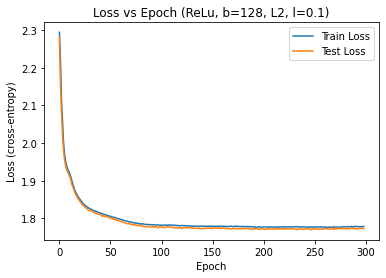

In [ ]:
plt.plot(range(0,299), train_loss_batch128, label='Train Loss')
plt.plot(range(0,299), test_loss_batch128, label='Test Loss')
plt.title('Loss vs Epoch (ReLu, b=128, L2, l=0.1)')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss (cross-entropy)')
plt.savefig('Loss_Epoch ReLu b=128 L2 l=0.1.pdf', format='pdf', bbox_inches='tight')
files.download('Loss_Epoch ReLu b=128 L2 l=0.1.pdf')
plt.show()

L2 with lambdaa = 0.01:

In [ ]:
model = MLP2(M=[256, 256], C=10, activation = Relu)
optimizer = SGDL2(learning_rate=.01, max_iters=150, Batch_size = 128, save_error = True, test_loss = True, lambdaa = 0.01)
model.fit(x_train, y_train, [x_test, y_test], optimizer)

Epoch: 1 / Train error: 2.29 / test error: 2.24
Epoch: 2 / Train error: 2.13 / test error: 2.02
Epoch: 3 / Train error: 1.95 / test error: 1.89
Epoch: 4 / Train error: 1.85 / test error: 1.8
Epoch: 5 / Train error: 1.78 / test error: 1.74
Epoch: 6 / Train error: 1.72 / test error: 1.68
Epoch: 7 / Train error: 1.67 / test error: 1.64
Epoch: 8 / Train error: 1.63 / test error: 1.61
Epoch: 9 / Train error: 1.59 / test error: 1.57
Epoch: 10 / Train error: 1.56 / test error: 1.55
Epoch: 11 / Train error: 1.52 / test error: 1.52
Epoch: 12 / Train error: 1.49 / test error: 1.5
Epoch: 13 / Train error: 1.47 / test error: 1.48
Epoch: 14 / Train error: 1.44 / test error: 1.46
Epoch: 15 / Train error: 1.42 / test error: 1.44
Epoch: 16 / Train error: 1.39 / test error: 1.42
Epoch: 17 / Train error: 1.37 / test error: 1.42
Epoch: 18 / Train error: 1.35 / test error: 1.4
Epoch: 19 / Train error: 1.33 / test error: 1.39
Epoch: 20 / Train error: 1.32 / test error: 1.38
Epoch: 21 / Train error: 1.3 / t

Test:

In [ ]:
yh_predict = model.predict(x_test)

In [ ]:
yh_predict = model.classify(yh_predict)

In [ ]:
model.accuracy(y_test_plot, yh_predict)

54.49

In [ ]:
train_loss_batch128 = model.print_Train_loss()

In [ ]:
test_loss_batch128 = model.print_Test_loss()

Train:

In [ ]:
yh_predict = model.predict(x_train)

In [ ]:
yh_predict = model.classify(yh_predict)

In [ ]:
model.accuracy(y_train_plot, yh_predict)

80.204

Cross entropy error:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

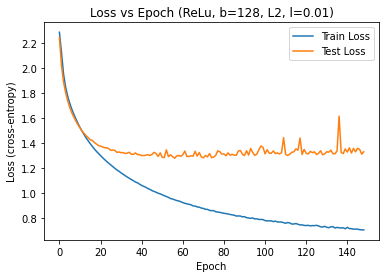

In [ ]:
plt.plot(range(0,149), train_loss_batch128, label='Train Loss')
plt.plot(range(0,149), test_loss_batch128, label='Test Loss')
plt.title('Loss vs Epoch (ReLu, b=128, L2, l=0.01)')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss (cross-entropy)')
plt.savefig('Loss_Epoch ReLu b=128 L2 l=0.01.pdf', format='pdf', bbox_inches='tight')
#files.download('Loss_Epoch ReLu b=128 L2 l=0.01.pdf')
plt.show()

L2 with lambdaa = 0.001:

In [ ]:
model = MLP2(M=[256, 256], C=10, activation = Relu)
optimizer = SGDL2(learning_rate=.01, max_iters=100, Batch_size = 128, save_error = True, test_loss = True, lambdaa = 0.001)
model.fit(x_train, y_train, [x_test, y_test], optimizer)

Epoch: 1 / Train error: 2.27 / test error: 2.2
Epoch: 2 / Train error: 2.09 / test error: 1.99
Epoch: 3 / Train error: 1.94 / test error: 1.88
Epoch: 4 / Train error: 1.84 / test error: 1.79
Epoch: 5 / Train error: 1.76 / test error: 1.72
Epoch: 6 / Train error: 1.69 / test error: 1.66
Epoch: 7 / Train error: 1.64 / test error: 1.61
Epoch: 8 / Train error: 1.59 / test error: 1.57
Epoch: 9 / Train error: 1.54 / test error: 1.53
Epoch: 10 / Train error: 1.5 / test error: 1.5
Epoch: 11 / Train error: 1.47 / test error: 1.48
Epoch: 12 / Train error: 1.43 / test error: 1.46
Epoch: 13 / Train error: 1.4 / test error: 1.44
Epoch: 14 / Train error: 1.37 / test error: 1.42
Epoch: 15 / Train error: 1.34 / test error: 1.41
Epoch: 16 / Train error: 1.32 / test error: 1.39
Epoch: 17 / Train error: 1.29 / test error: 1.38
Epoch: 18 / Train error: 1.27 / test error: 1.37
Epoch: 19 / Train error: 1.24 / test error: 1.36
Epoch: 20 / Train error: 1.22 / test error: 1.37
Epoch: 21 / Train error: 1.2 / te

Test:

In [ ]:
yh_predict = model.predict(x_test)

In [ ]:
yh_predict = model.classify(yh_predict)

In [ ]:
model.accuracy(y_test_plot, yh_predict)

52.470000000000006

In [ ]:
train_loss_batch128 = model.print_Train_loss()

In [ ]:
test_loss_batch128 = model.print_Test_loss()

Train:

In [ ]:
yh_predict = model.predict(x_train)

In [ ]:
yh_predict = model.classify(yh_predict)

In [ ]:
model.accuracy(y_train_plot, yh_predict)

59.897999999999996

Cross entropy error:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

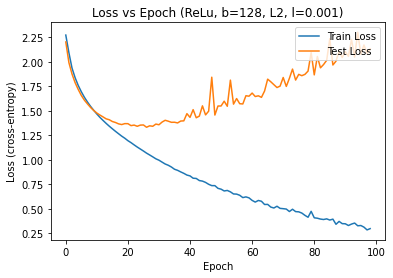

In [ ]:
plt.plot(range(0,99), train_loss_batch128, label='Train Loss')
plt.plot(range(0,99), test_loss_batch128, label='Test Loss')
plt.title('Loss vs Epoch (ReLu, b=128, L2, l=0.001)')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss (cross-entropy)')
plt.savefig('Loss_Epoch ReLu b=128 L2 l=0.001.pdf', format='pdf', bbox_inches='tight')
#files.download('Loss_Epoch ReLu b=128 L2 l=0.001.pdf')
plt.show()

CNN:

In [ ]:
x_train = x_train.reshape(50000,32,32,3)
x_test = x_test.reshape(10000,32,32,3)

## Defining model with 2 convolutional layers and two fully connected layers

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pickle

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import SGD

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

W_init = model.get_weights()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 256)               5

##Learning rate =0.001; Batch sizes= 32, 64, 128

In [ ]:
model.set_weights(W_init)
model.compile(optimizer=SGD(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_test, y_test))
with open("history.pkl", 'wb') as file:
    pickle.dump(history, file)

Epoch 1/25
1563/1563 [==============================] - 18s 6ms/step - loss: 2.1900 - accuracy: 0.2159 - val_loss: 2.0145 - val_accuracy: 0.2930
Epoch 2/25
1563/1563 [==============================] - 9s 6ms/step - loss: 1.9048 - accuracy: 0.3236 - val_loss: 1.8115 - val_accuracy: 0.3542
Epoch 3/25
1563/1563 [==============================] - 9s 6ms/step - loss: 1.7435 - accuracy: 0.3839 - val_loss: 1.6661 - val_accuracy: 0.4144
Epoch 4/25
1563/1563 [==============================] - 8s 5ms/step - loss: 1.6155 - accuracy: 0.4282 - val_loss: 1.5580 - val_accuracy: 0.4440
Epoch 5/25
1563/1563 [==============================] - 9s 6ms/step - loss: 1.5198 - accuracy: 0.4588 - val_loss: 1.4760 - val_accuracy: 0.4787
Epoch 6/25
1563/1563 [==============================] - 9s 6ms/step - loss: 1.4431 - accuracy: 0.4881 - val_loss: 1.4176 - val_accuracy: 0.4943
Epoch 7/25
1563/1563 [==============================] - 9s 6ms/step - loss: 1.3858 - accuracy: 0.5070 - val_loss: 1.3939 - val_accuracy

In [ ]:
model.set_weights(W_init)
model.compile(optimizer=SGD(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history1 = model.fit(x_train, y_train, epochs=25, batch_size=64, validation_data=(x_test, y_test))
with open("history1.pkl", 'wb') as file:
    pickle.dump(history1, file)

Epoch 1/25
782/782 [==============================] - 6s 7ms/step - loss: 2.2670 - accuracy: 0.1694 - val_loss: 2.2013 - val_accuracy: 0.2366
Epoch 2/25
782/782 [==============================] - 5s 6ms/step - loss: 2.1102 - accuracy: 0.2653 - val_loss: 2.0127 - val_accuracy: 0.2926
Epoch 3/25
782/782 [==============================] - 5s 6ms/step - loss: 1.9512 - accuracy: 0.3088 - val_loss: 1.8910 - val_accuracy: 0.3334
Epoch 4/25
782/782 [==============================] - 5s 6ms/step - loss: 1.8526 - accuracy: 0.3411 - val_loss: 1.8070 - val_accuracy: 0.3588
Epoch 5/25
782/782 [==============================] - 5s 6ms/step - loss: 1.7738 - accuracy: 0.3737 - val_loss: 1.7317 - val_accuracy: 0.3952
Epoch 6/25
782/782 [==============================] - 5s 6ms/step - loss: 1.6998 - accuracy: 0.3996 - val_loss: 1.6633 - val_accuracy: 0.4159
Epoch 7/25
782/782 [==============================] - 5s 6ms/step - loss: 1.6351 - accuracy: 0.4238 - val_loss: 1.6037 - val_accuracy: 0.4360
Epoch 

In [ ]:
model.set_weights(W_init)
model.compile(optimizer=SGD(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history2 = model.fit(x_train, y_train, epochs=25, batch_size=128, validation_data=(x_test, y_test))
with open("history2.pkl", 'wb') as file:
    pickle.dump(history2, file)

Epoch 1/25
391/391 [==============================] - 5s 8ms/step - loss: 2.2982 - accuracy: 0.1298 - val_loss: 2.2656 - val_accuracy: 0.1807
Epoch 2/25
391/391 [==============================] - 3s 7ms/step - loss: 2.2355 - accuracy: 0.2126 - val_loss: 2.2012 - val_accuracy: 0.2394
Epoch 3/25
391/391 [==============================] - 3s 7ms/step - loss: 2.1580 - accuracy: 0.2524 - val_loss: 2.1081 - val_accuracy: 0.2697
Epoch 4/25
391/391 [==============================] - 3s 8ms/step - loss: 2.0605 - accuracy: 0.2783 - val_loss: 2.0118 - val_accuracy: 0.2928
Epoch 5/25
391/391 [==============================] - 3s 7ms/step - loss: 1.9792 - accuracy: 0.2996 - val_loss: 1.9424 - val_accuracy: 0.3108
Epoch 6/25
391/391 [==============================] - 3s 7ms/step - loss: 1.9192 - accuracy: 0.3193 - val_loss: 1.8896 - val_accuracy: 0.3332
Epoch 7/25
391/391 [==============================] - 3s 7ms/step - loss: 1.8708 - accuracy: 0.3360 - val_loss: 1.8450 - val_accuracy: 0.3483
Epoch 

##Learning rate =0.01; Batch sizes= 32, 64, 128

In [ ]:
model.set_weights(W_init)
model.compile(optimizer=SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history3 = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_test, y_test))
with open("history3.pkl", 'wb') as file:
    pickle.dump(history3, file)

Epoch 1/25
1563/1563 [==============================] - 11s 6ms/step - loss: 1.6721 - accuracy: 0.3975 - val_loss: 1.3927 - val_accuracy: 0.5007
Epoch 2/25
1563/1563 [==============================] - 9s 6ms/step - loss: 1.2949 - accuracy: 0.5396 - val_loss: 1.2514 - val_accuracy: 0.5478
Epoch 3/25
1563/1563 [==============================] - 9s 6ms/step - loss: 1.1353 - accuracy: 0.5996 - val_loss: 1.1461 - val_accuracy: 0.5881
Epoch 4/25
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0207 - accuracy: 0.6428 - val_loss: 1.0150 - val_accuracy: 0.6508
Epoch 5/25
1563/1563 [==============================] - 9s 6ms/step - loss: 0.9255 - accuracy: 0.6782 - val_loss: 0.9955 - val_accuracy: 0.6522
Epoch 6/25
1563/1563 [==============================] - 9s 6ms/step - loss: 0.8510 - accuracy: 0.7044 - val_loss: 0.9320 - val_accuracy: 0.6737
Epoch 7/25
1563/1563 [==============================] - 8s 5ms/step - loss: 0.7806 - accuracy: 0.7279 - val_loss: 0.8957 - val_accuracy

In [ ]:
model.set_weights(W_init)
model.compile(optimizer=SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history4 = model.fit(x_train, y_train, epochs=25, batch_size=64, validation_data=(x_test, y_test))
with open("history4.pkl", 'wb') as file:
    pickle.dump(history4, file)

Epoch 1/25
782/782 [==============================] - 6s 7ms/step - loss: 1.8302 - accuracy: 0.3419 - val_loss: 1.6914 - val_accuracy: 0.3839
Epoch 2/25
782/782 [==============================] - 4s 6ms/step - loss: 1.4368 - accuracy: 0.4851 - val_loss: 1.3407 - val_accuracy: 0.5212
Epoch 3/25
782/782 [==============================] - 5s 7ms/step - loss: 1.2916 - accuracy: 0.5421 - val_loss: 1.3517 - val_accuracy: 0.5205
Epoch 4/25
782/782 [==============================] - 5s 6ms/step - loss: 1.1910 - accuracy: 0.5812 - val_loss: 1.2551 - val_accuracy: 0.5539
Epoch 5/25
782/782 [==============================] - 4s 6ms/step - loss: 1.1071 - accuracy: 0.6115 - val_loss: 1.3000 - val_accuracy: 0.5584
Epoch 6/25
782/782 [==============================] - 5s 6ms/step - loss: 1.0356 - accuracy: 0.6370 - val_loss: 1.2305 - val_accuracy: 0.5723
Epoch 7/25
782/782 [==============================] - 5s 6ms/step - loss: 0.9775 - accuracy: 0.6573 - val_loss: 1.2163 - val_accuracy: 0.5770
Epoch 

In [ ]:
model.set_weights(W_init)
model.compile(optimizer=SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history5 = model.fit(x_train, y_train, epochs=25, batch_size=128, validation_data=(x_test, y_test))
with open("history5.pkl", 'wb') as file:
    pickle.dump(history5, file)

Epoch 1/25
391/391 [==============================] - 4s 8ms/step - loss: 2.0015 - accuracy: 0.2848 - val_loss: 1.7554 - val_accuracy: 0.3683
Epoch 2/25
391/391 [==============================] - 3s 8ms/step - loss: 1.6250 - accuracy: 0.4203 - val_loss: 1.5430 - val_accuracy: 0.4456
Epoch 3/25
391/391 [==============================] - 3s 7ms/step - loss: 1.4519 - accuracy: 0.4824 - val_loss: 1.4192 - val_accuracy: 0.4930
Epoch 4/25
391/391 [==============================] - 3s 7ms/step - loss: 1.3568 - accuracy: 0.5154 - val_loss: 1.3346 - val_accuracy: 0.5197
Epoch 5/25
391/391 [==============================] - 3s 7ms/step - loss: 1.2863 - accuracy: 0.5451 - val_loss: 1.2959 - val_accuracy: 0.5400
Epoch 6/25
391/391 [==============================] - 3s 8ms/step - loss: 1.2263 - accuracy: 0.5673 - val_loss: 1.2455 - val_accuracy: 0.5607
Epoch 7/25
391/391 [==============================] - 3s 7ms/step - loss: 1.1731 - accuracy: 0.5870 - val_loss: 1.2526 - val_accuracy: 0.5663
Epoch 

##Learning rate =0.1; Batch sizes= 32, 64, 128

In [ ]:
model.set_weights(W_init)
model.compile(optimizer=SGD(learning_rate=0.1),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history6 = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_test, y_test))
with open("history6.pkl", 'wb') as file:
    pickle.dump(history6, file)

Epoch 1/25
1563/1563 [==============================] - 11s 6ms/step - loss: 1.4347 - accuracy: 0.4851 - val_loss: 1.1437 - val_accuracy: 0.5912
Epoch 2/25
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0133 - accuracy: 0.6453 - val_loss: 1.0951 - val_accuracy: 0.6180
Epoch 3/25
1563/1563 [==============================] - 9s 6ms/step - loss: 0.8149 - accuracy: 0.7150 - val_loss: 0.9736 - val_accuracy: 0.6584
Epoch 4/25
1563/1563 [==============================] - 9s 6ms/step - loss: 0.6615 - accuracy: 0.7678 - val_loss: 0.9385 - val_accuracy: 0.6953
Epoch 5/25
1563/1563 [==============================] - 9s 6ms/step - loss: 0.5436 - accuracy: 0.8107 - val_loss: 1.0516 - val_accuracy: 0.6848
Epoch 6/25
1563/1563 [==============================] - 11s 7ms/step - loss: 0.4334 - accuracy: 0.8471 - val_loss: 1.0742 - val_accuracy: 0.6855
Epoch 7/25
1563/1563 [==============================] - 9s 6ms/step - loss: 0.3531 - accuracy: 0.8769 - val_loss: 1.2528 - val_accurac

In [ ]:
model.set_weights(W_init)
model.compile(optimizer=SGD(learning_rate=0.1),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history7 = model.fit(x_train, y_train, epochs=25, batch_size=64, validation_data=(x_test, y_test))
with open("history7.pkl", 'wb') as file:
    pickle.dump(history7, file)

Epoch 1/25
782/782 [==============================] - 6s 6ms/step - loss: 1.5068 - accuracy: 0.4588 - val_loss: 1.4579 - val_accuracy: 0.4713
Epoch 2/25
782/782 [==============================] - 5s 6ms/step - loss: 1.0836 - accuracy: 0.6214 - val_loss: 1.2566 - val_accuracy: 0.5538
Epoch 3/25
782/782 [==============================] - 5s 6ms/step - loss: 0.8778 - accuracy: 0.6943 - val_loss: 1.0832 - val_accuracy: 0.6350
Epoch 4/25
782/782 [==============================] - 4s 6ms/step - loss: 0.7240 - accuracy: 0.7460 - val_loss: 1.1140 - val_accuracy: 0.6423
Epoch 5/25
782/782 [==============================] - 5s 6ms/step - loss: 0.5871 - accuracy: 0.7953 - val_loss: 1.1753 - val_accuracy: 0.6288
Epoch 6/25
782/782 [==============================] - 5s 6ms/step - loss: 0.4693 - accuracy: 0.8353 - val_loss: 1.0274 - val_accuracy: 0.6827
Epoch 7/25
782/782 [==============================] - 4s 6ms/step - loss: 0.3721 - accuracy: 0.8680 - val_loss: 1.1307 - val_accuracy: 0.6855
Epoch 

In [ ]:
model.set_weights(W_init)
model.compile(optimizer=SGD(learning_rate=0.1),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history8 = model.fit(x_train, y_train, epochs=25, batch_size=128, validation_data=(x_test, y_test))
with open("history8.pkl", 'wb') as file:
    pickle.dump(history8, file)

Epoch 1/25
391/391 [==============================] - 5s 8ms/step - loss: 1.6359 - accuracy: 0.4081 - val_loss: 1.3651 - val_accuracy: 0.5102
Epoch 2/25
391/391 [==============================] - 3s 7ms/step - loss: 1.2319 - accuracy: 0.5663 - val_loss: 1.4359 - val_accuracy: 0.5211
Epoch 3/25
391/391 [==============================] - 3s 7ms/step - loss: 1.0246 - accuracy: 0.6401 - val_loss: 0.9726 - val_accuracy: 0.6623
Epoch 4/25
391/391 [==============================] - 3s 7ms/step - loss: 0.8838 - accuracy: 0.6906 - val_loss: 0.9892 - val_accuracy: 0.6570
Epoch 5/25
391/391 [==============================] - 3s 7ms/step - loss: 0.7592 - accuracy: 0.7357 - val_loss: 1.0164 - val_accuracy: 0.6549
Epoch 6/25
391/391 [==============================] - 3s 6ms/step - loss: 0.6494 - accuracy: 0.7735 - val_loss: 0.9055 - val_accuracy: 0.6929
Epoch 7/25
391/391 [==============================] - 2s 6ms/step - loss: 0.5523 - accuracy: 0.8072 - val_loss: 0.9681 - val_accuracy: 0.6902
Epoch 

## Read trained model histories from files (only for running without retraining)

In [ ]:
import pickle
file_names=[]
nos=['']
nos.extend(np.arange(1,9))
file_names.append('history')
history=[]
for f in nos:
  file = open(file_names[0]+str(f)+'.pkl','rb')
  history.append(pickle.load(file))
  file.close()

Keras model archive loading:
File Name                                             Modified             Size
variables.h5                                   2023-03-06 20:24:50      5458056
metadata.json                                  2023-03-06 20:24:50           64
config.json                                    2023-03-06 20:24:50         3897
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......flatten
.........vars
......max_pooling2d
.........vars
......max_pooling2d_1
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........

##Generate plots

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

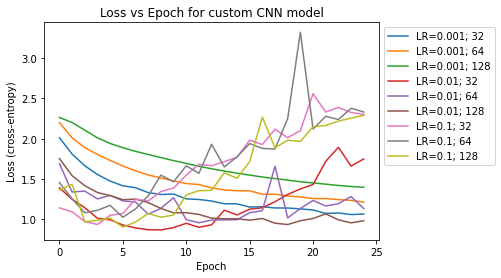

In [ ]:
from google.colab import files
labels=['LR=0.001; 32', 'LR=0.001; 64', 'LR=0.001; 128', 'LR=0.01; 32', 'LR=0.01; 64', 'LR=0.01; 128', 'LR=0.1; 32', 'LR=0.1; 64', 'LR=0.1; 128']
for i in range(len(history)):
  plt.plot(history[i].history['val_loss'], label = labels[i])
  #plt.plot(history[i].history['loss'], label = "Train loss:"+labels[i])
plt.title('Loss vs Epoch for custom CNN model')
plt.xlabel('Epoch')
plt.ylabel('Loss (cross-entropy)')
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig('Loss_Epoch Hyperparameter search for Custom CNN model.pdf', format='pdf', bbox_inches='tight')
files.download('Loss_Epoch Hyperparameter search for Custom CNN model.pdf')
plt.show()
#test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

## Find the best hyperparameters for the model

In [ ]:
label=labels[0]
minimum=np.min(history[0].history['val_loss'])
min_i=0
epoch=history[0].history['val_loss'].index(minimum)
for i in range(1,len(history)):
  if np.min(history[i].history['val_loss'])< minimum:
    label=labels[i]
    minimum=np.min(history[i].history['val_loss'])
    min_i=i
    epoch=history[i].history['val_loss'].index(minimum)

print("Minimum loss observed at", label, 'at epoch', epoch+1)
print("Accuracy at this point is", 100*history[min_i].history['val_accuracy'][epoch], "%")

Minimum loss observed at LR=0.01; 32 at epoch 9
Accuracy at this point is 69.85999941825867 %


## Defining model with dropout

In [ ]:
model1 = models.Sequential()
model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Flatten())
model1.add(layers.Dense(256, activation='relu'))
model1.add(layers.Dense(256, activation='relu'))
model1.add(layers.Dropout(0.4))
model1.add(layers.Dense(10, activation='softmax'))
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 2304)              0         
                                                                 
 dense_6 (Dense)             (None, 256)              

In [ ]:
model1.set_weights(W_init)
model1.compile(optimizer=SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history1 = model1.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/25
1563/1563 [==============================] - 11s 6ms/step - loss: 1.7590 - accuracy: 0.3602 - val_loss: 1.4077 - val_accuracy: 0.4941
Epoch 2/25
1563/1563 [==============================] - 11s 7ms/step - loss: 1.3882 - accuracy: 0.5036 - val_loss: 1.3282 - val_accuracy: 0.5267
Epoch 3/25
1563/1563 [==============================] - 10s 6ms/step - loss: 1.2282 - accuracy: 0.5640 - val_loss: 1.1478 - val_accuracy: 0.5905
Epoch 4/25
1563/1563 [==============================] - 9s 6ms/step - loss: 1.1120 - accuracy: 0.6078 - val_loss: 1.0754 - val_accuracy: 0.6197
Epoch 5/25
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0266 - accuracy: 0.6398 - val_loss: 1.0568 - val_accuracy: 0.6229
Epoch 6/25
1563/1563 [==============================] - 9s 6ms/step - loss: 0.9585 - accuracy: 0.6643 - val_loss: 1.0179 - val_accuracy: 0.6448
Epoch 7/25
1563/1563 [==============================] - 10s 6ms/step - loss: 0.8998 - accuracy: 0.6846 - val_loss: 0.9332 - val_accur

In [ ]:
with open("history_withdropout.pkl", 'wb') as file:
    pickle.dump(history1, file)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dropout
.........vars
......flatten
.........vars
......max_pooling2d
.........vars
......max_pooling2d_1
.........vars
...optimizer
......vars
.........0
...vars
Keras model archive saving:
File Name                                             Modified             Size
variables.h5                                   2023-03-08 15:43:05      2738568
config.json                                    2023-03-08 15:43:05         4055
metadata.json                                  2023-03-08 15:43:05           64


## Read trained model histories from files (only for running without retraining)

In [ ]:
file = open('history_withdropout.pkl','rb')
history1= pickle.load(file)
file.close()

Keras model archive loading:
File Name                                             Modified             Size
variables.h5                                   2023-03-06 21:36:06      5460096
metadata.json                                  2023-03-06 21:36:06           64
config.json                                    2023-03-06 21:36:06         4055
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dropout
.........vars
......flatten
.........vars
......max_pooling2d
.........vars
......max_pooling2d_1
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
....

## Finding best epoch for comparison

In [ ]:
minimum1=np.min(history1.history['val_loss'])
epoch1=history1.history['val_loss'].index(minimum1)
print("Minimum loss for model with dropout is observed at epoch", epoch1+1)
print("Accuracy at this point is", 100*history1.history['val_accuracy'][epoch1], "%")

Minimum loss for model with dropout is observed at epoch 15
Accuracy at this point is 72.75000214576721 %


## Generate plots

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

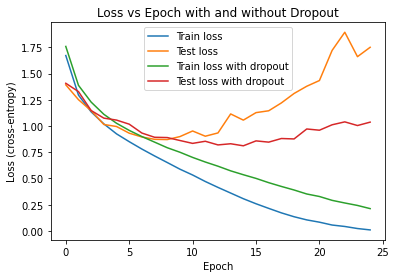

In [ ]:
from google.colab import files


plt.plot(history[min_i].history['loss'], label='Train loss')
plt.plot(history[min_i].history['val_loss'], label = 'Test loss')

plt.plot(history1.history['loss'], label='Train loss with dropout')
plt.plot(history1.history['val_loss'], label = 'Test loss with dropout')

plt.legend()
plt.title('Loss vs Epoch with and without Dropout')
plt.xlabel('Epoch')
plt.ylabel('Loss (cross-entropy)')
plt.savefig('Loss_Epoch with and without Dropout.pdf', format='pdf', bbox_inches='tight')
files.download('Loss_Epoch with and without Dropout.pdf')
plt.show()

Text(0, 0.5, 'Accuracy')

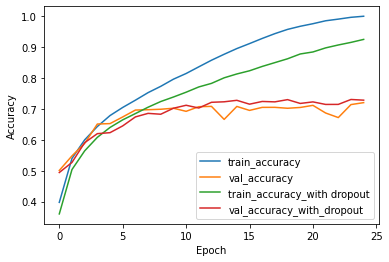

In [ ]:
plt.plot(history[min_i].history['accuracy'], label='train_accuracy')
plt.plot(history[min_i].history['val_accuracy'], label = 'val_accuracy')

plt.plot(history1.history['accuracy'], label='train_accuracy_with dropout')
plt.plot(history1.history['val_accuracy'], label = 'val_accuracy_with_dropout')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

VGG19:

##Analysis using Pre-trained model

In [ ]:
# VGG19 Model
from keras.applications.vgg19 import VGG19

# Preparing VGG19 Model
from keras.layers import Dense,Flatten,Input
from keras.models import Sequential

In [ ]:
base_model = VGG19(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=y_train.shape[1])

## Defining model with different number of fully connected layers for comparison

In [ ]:
model2= models.Sequential()
model2.add(base_model)
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(10, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

model2.compile(optimizer=SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                2570      
                                                                 
Total params: 20,158,282
Trainable params: 133,898
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
history2 = model2.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_test, y_test))
with open("history_cnn.pkl", 'wb') as file:
    pickle.dump(history2, file)

Epoch 1/25
1563/1563 [==============================] - 27s 12ms/step - loss: 1.5996 - accuracy: 0.4355 - val_loss: 1.3053 - val_accuracy: 0.5503
Epoch 2/25
1563/1563 [==============================] - 18s 12ms/step - loss: 1.3201 - accuracy: 0.5360 - val_loss: 1.2051 - val_accuracy: 0.5819
Epoch 3/25
1563/1563 [==============================] - 18s 12ms/step - loss: 1.2451 - accuracy: 0.5654 - val_loss: 1.1566 - val_accuracy: 0.5971
Epoch 4/25
1563/1563 [==============================] - 19s 12ms/step - loss: 1.1964 - accuracy: 0.5829 - val_loss: 1.1271 - val_accuracy: 0.6077
Epoch 5/25
1563/1563 [==============================] - 19s 12ms/step - loss: 1.1654 - accuracy: 0.5918 - val_loss: 1.1127 - val_accuracy: 0.6103
Epoch 6/25
1563/1563 [==============================] - 19s 12ms/step - loss: 1.1401 - accuracy: 0.6007 - val_loss: 1.0926 - val_accuracy: 0.6155
Epoch 7/25
1563/1563 [==============================] - 19s 12ms/step - loss: 1.1209 - accuracy: 0.6055 - val_loss: 1.0922 -

In [ ]:
model3= models.Sequential()
model3.add(base_model)
model3.add(layers.Flatten())
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dense(10, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

model3.compile(optimizer=SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 10)                2570      
                                                                 
Total params: 20,224,074
Trainable params: 199,690
Non

In [ ]:
history3 = model3.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_test, y_test))
with open("history_cnn1.pkl", 'wb') as file:
    pickle.dump(history3, file)

Epoch 1/40
1563/1563 [==============================] - 19s 12ms/step - loss: 1.0862 - accuracy: 0.6205 - val_loss: 1.0607 - val_accuracy: 0.6282
Epoch 2/40
1563/1563 [==============================] - 19s 12ms/step - loss: 1.0657 - accuracy: 0.6272 - val_loss: 1.0498 - val_accuracy: 0.6323
Epoch 3/40
1563/1563 [==============================] - 19s 12ms/step - loss: 1.0535 - accuracy: 0.6312 - val_loss: 1.0502 - val_accuracy: 0.6338
Epoch 4/40
1563/1563 [==============================] - 19s 12ms/step - loss: 1.0339 - accuracy: 0.6386 - val_loss: 1.0415 - val_accuracy: 0.6368
Epoch 5/40
1563/1563 [==============================] - 19s 12ms/step - loss: 1.0246 - accuracy: 0.6435 - val_loss: 1.0438 - val_accuracy: 0.6370
Epoch 6/40
1563/1563 [==============================] - 19s 12ms/step - loss: 1.0112 - accuracy: 0.6479 - val_loss: 1.0255 - val_accuracy: 0.6430
Epoch 7/40
1563/1563 [==============================] - 19s 12ms/step - loss: 0.9992 - accuracy: 0.6506 - val_loss: 1.0338 -

In [ ]:
model4= models.Sequential()
model4.add(base_model)
model4.add(layers.Flatten())
model4.add(layers.Dense(256, activation='relu'))
model4.add(layers.Dense(256, activation='relu'))
model4.add(layers.Dense(256, activation='relu'))
model4.add(layers.Dense(10, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

model4.compile(optimizer=SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model4.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_9 (Flatten)         (None, 512)               0         
                                                                 
 dense_24 (Dense)            (None, 256)               131328    
                                                                 
 dense_25 (Dense)            (None, 256)               65792     
                                                                 
 dense_26 (Dense)            (None, 256)               65792     
                                                                 
 dense_27 (Dense)            (None, 10)                2570      
                                                                 
Total params: 20,289,866
Trainable params: 265,482
Non

In [ ]:
history4 = model4.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_test, y_test))
with open("history_cnn2.pkl", 'wb') as file:
    pickle.dump(history4, file)

Epoch 1/25
1563/1563 [==============================] - 21s 13ms/step - loss: 1.4708 - accuracy: 0.4831 - val_loss: 1.2623 - val_accuracy: 0.5585
Epoch 2/25
1563/1563 [==============================] - 19s 12ms/step - loss: 1.1766 - accuracy: 0.5871 - val_loss: 1.1657 - val_accuracy: 0.5951
Epoch 3/25
1563/1563 [==============================] - 19s 12ms/step - loss: 1.1079 - accuracy: 0.6106 - val_loss: 1.1511 - val_accuracy: 0.5937
Epoch 4/25
1563/1563 [==============================] - 19s 12ms/step - loss: 1.0673 - accuracy: 0.6237 - val_loss: 1.1200 - val_accuracy: 0.6039
Epoch 5/25
1563/1563 [==============================] - 19s 12ms/step - loss: 1.0356 - accuracy: 0.6352 - val_loss: 1.0734 - val_accuracy: 0.6250
Epoch 6/25
1563/1563 [==============================] - 19s 12ms/step - loss: 1.0091 - accuracy: 0.6431 - val_loss: 1.0696 - val_accuracy: 0.6220
Epoch 7/25
1563/1563 [==============================] - 19s 12ms/step - loss: 0.9861 - accuracy: 0.6529 - val_loss: 1.0488 -

## Read trained model histories from files (only for running without retraining)

In [ ]:
file_names=[]
nos=['']
nos.extend(np.arange(1,3))
file_names.append('history_cnn')
history2=[]
for f in nos:
  file = open(file_names[0]+str(f)+'.pkl','rb')
  history2.append(pickle.load(file))
  file.close()

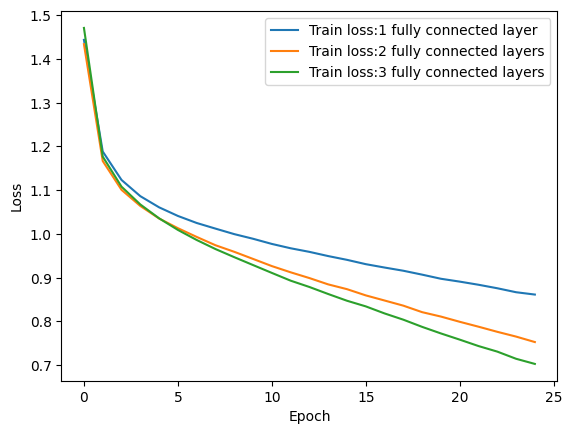

In [ ]:
labels=['1 fully connected layer', '2 fully connected layers', '3 fully connected layers']
for i in range(len(history2)):
  #plt.plot(history2[i].history['val_loss'], label = labels[i])
  plt.plot(history2[i].history['loss'], label = "Train loss:"+labels[i])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1, 1))
#test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

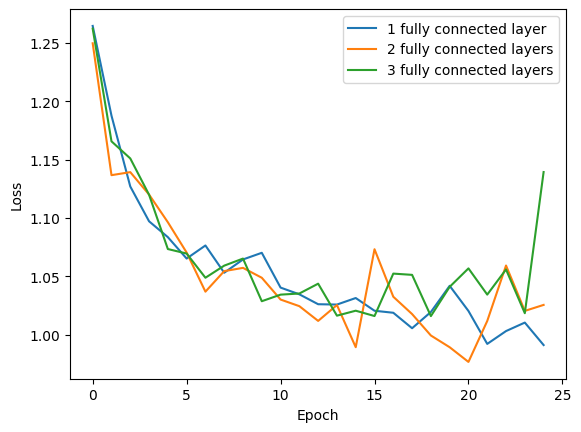

In [ ]:
labels=['1 fully connected layer', '2 fully connected layers','3 fully connected layers']
for i in range(len(history2)):
  plt.plot(history2[i].history['val_loss'], label = labels[i])
  #plt.plot(history[i].history['loss'], label = "Train loss:"+labels[i])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1, 1))
#test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

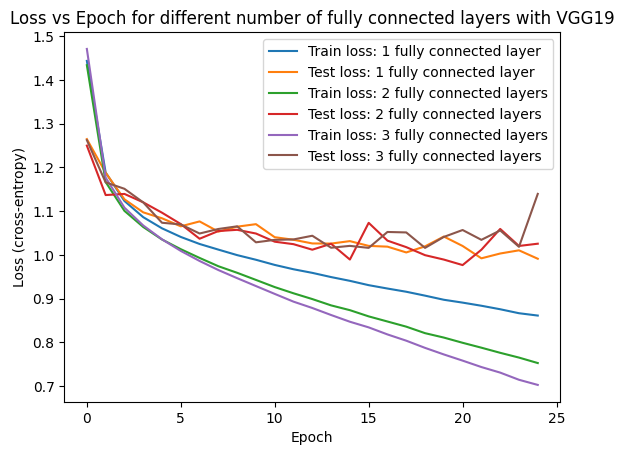

In [ ]:
from google.colab import files


labels=['1 fully connected layer', '2 fully connected layers', '3 fully connected layers']
for i in range(len(history2)):
  plt.plot(history2[i].history['loss'], label = "Train loss: "+labels[i])
  plt.plot(history2[i].history['val_loss'], label = "Test loss: "+labels[i])
plt.title('Loss vs Epoch for different number of fully connected layers with VGG19')
plt.xlabel('Epoch')
plt.ylabel('Loss (cross-entropy)')
plt.legend(bbox_to_anchor=(1, 1))

# plt.savefig('Loss_Epoch different hidden layer count.pdf', format='pdf', bbox_inches='tight')
# files.download('Loss_Epoch different hidden layer count.pdf')
plt.show()

In [ ]:
label=labels[0]
minimum=np.min(history2[0].history['val_loss'])
min_i=0
epoch=history2[0].history['val_loss'].index(minimum)
for i in range(1,len(history2)):
  if np.min(history2[i].history['val_loss'])< minimum:
    label=labels[i]
    minimum=np.min(history2[i].history['val_loss'])
    min_i=i
    epoch=history2[i].history['val_loss'].index(minimum)

print("Minimum loss observed with", label, 'at epoch', epoch+1)
print("Minimum loss is", minimum)
print("Accuracy at this point is", 100*history2[min_i].history['val_accuracy'][epoch], "%")

Minimum loss observed with 2 fully connected layers at epoch 21
Minimum loss is 0.9767130017280579
Accuracy at this point is 66.36999845504761 %


## Defining models with different number of units in the 2 fully connected layers for comparison

In [ ]:
model5= models.Sequential()
model5.add(base_model)
model5.add(layers.Flatten())
model5.add(layers.Dense(256, activation='relu'))
model5.add(layers.Dense(128, activation='relu'))
model5.add(layers.Dense(10, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

model5.compile(optimizer=SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dense_13 (Dense)            (None, 10)                1290      
                                                                 
Total params: 20,189,898
Trainable params: 165,514
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
history3 = model5.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_test, y_test))
with open("history_cnn_2layer1.pkl", 'wb') as file:
    pickle.dump(history3, file)

Epoch 1/25
1563/1563 [==============================] - 32s 15ms/step - loss: 1.4346 - accuracy: 0.4973 - val_loss: 1.2111 - val_accuracy: 0.5758
Epoch 2/25
1563/1563 [==============================] - 23s 15ms/step - loss: 1.1714 - accuracy: 0.5898 - val_loss: 1.1507 - val_accuracy: 0.5958
Epoch 3/25
1563/1563 [==============================] - 23s 14ms/step - loss: 1.1053 - accuracy: 0.6133 - val_loss: 1.1546 - val_accuracy: 0.5871
Epoch 4/25
1563/1563 [==============================] - 20s 13ms/step - loss: 1.0649 - accuracy: 0.6283 - val_loss: 1.0938 - val_accuracy: 0.6180
Epoch 5/25
1563/1563 [==============================] - 22s 14ms/step - loss: 1.0370 - accuracy: 0.6377 - val_loss: 1.0980 - val_accuracy: 0.6111
Epoch 6/25
1563/1563 [==============================] - 21s 13ms/step - loss: 1.0141 - accuracy: 0.6446 - val_loss: 1.0634 - val_accuracy: 0.6262
Epoch 7/25
1563/1563 [==============================] - 23s 14ms/step - loss: 0.9933 - accuracy: 0.6528 - val_loss: 1.0799 -

In [ ]:
minimum2=np.min(history3.history['val_loss'])
epoch2=history3.history['val_loss'].index(minimum2)
print("Minimum loss for model is observed at epoch", epoch2+1)
print("Minimum loss is", minimum2)
print("Accuracy at this point is", 100*history3.history['val_accuracy'][epoch2], "%")

Minimum loss for model is observed at epoch 22
Minimum loss is 0.9972996115684509
Accuracy at this point is 65.59000015258789 %


In [ ]:
model6= models.Sequential()
model6.add(base_model)
model6.add(layers.Flatten())
model6.add(layers.Dense(512, activation='relu'))
model6.add(layers.Dense(256, activation='relu'))
model6.add(layers.Dense(10, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

model6.compile(optimizer=SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model6.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 10)                2570      
                                                                 
Total params: 20,420,938
Trainable params: 396,554
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
history4 = model6.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_test, y_test))
with open("history_cnn_2layer2.pkl", 'wb') as file:
    pickle.dump(history4, file)

Epoch 1/25
1563/1563 [==============================] - 25s 15ms/step - loss: 1.4059 - accuracy: 0.5091 - val_loss: 1.2185 - val_accuracy: 0.5711
Epoch 2/25
1563/1563 [==============================] - 20s 13ms/step - loss: 1.1530 - accuracy: 0.5962 - val_loss: 1.1698 - val_accuracy: 0.5940
Epoch 3/25
1563/1563 [==============================] - 20s 13ms/step - loss: 1.0895 - accuracy: 0.6200 - val_loss: 1.1357 - val_accuracy: 0.5952
Epoch 4/25
1563/1563 [==============================] - 22s 14ms/step - loss: 1.0503 - accuracy: 0.6312 - val_loss: 1.1027 - val_accuracy: 0.6138
Epoch 5/25
1563/1563 [==============================] - 23s 14ms/step - loss: 1.0219 - accuracy: 0.6415 - val_loss: 1.0886 - val_accuracy: 0.6136
Epoch 6/25
1563/1563 [==============================] - 20s 13ms/step - loss: 0.9969 - accuracy: 0.6494 - val_loss: 1.0541 - val_accuracy: 0.6252
Epoch 7/25
1563/1563 [==============================] - 23s 14ms/step - loss: 0.9750 - accuracy: 0.6579 - val_loss: 1.0762 -

In [ ]:
minimum3=np.min(history4.history['val_loss'])
epoch3=history4.history['val_loss'].index(minimum3)
print("Minimum loss for model is observed at epoch", epoch3+1)
print("Minimum loss is", minimum3)
print("Accuracy at this point is", 100*history3.history['val_accuracy'][epoch3], "%")

Minimum loss for model is observed at epoch 25
Minimum loss is 0.9800328016281128
Accuracy at this point is 64.85000252723694 %


In [ ]:
model7= models.Sequential()
model7.add(base_model)
model7.add(layers.Flatten())
model7.add(layers.Dense(512, activation='relu'))
model7.add(layers.Dense(512, activation='relu'))
model7.add(layers.Dense(10, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

model7.compile(optimizer=SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model7.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dense_7 (Dense)             (None, 512)               262656    
                                                                 
 dense_8 (Dense)             (None, 10)                5130      
                                                                 
Total params: 20,554,826
Trainable params: 530,442
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
history5 = model7.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_test, y_test))
with open("history_cnn_2layer3.pkl", 'wb') as file:
    pickle.dump(history5, file)

Epoch 1/25
1563/1563 [==============================] - 23s 14ms/step - loss: 1.4079 - accuracy: 0.5101 - val_loss: 1.2374 - val_accuracy: 0.5656
Epoch 2/25
1563/1563 [==============================] - 24s 15ms/step - loss: 1.1546 - accuracy: 0.5935 - val_loss: 1.2065 - val_accuracy: 0.5808
Epoch 3/25
1563/1563 [==============================] - 22s 14ms/step - loss: 1.0896 - accuracy: 0.6173 - val_loss: 1.1173 - val_accuracy: 0.6049
Epoch 4/25
1563/1563 [==============================] - 21s 13ms/step - loss: 1.0495 - accuracy: 0.6316 - val_loss: 1.0906 - val_accuracy: 0.6179
Epoch 5/25
1563/1563 [==============================] - 22s 14ms/step - loss: 1.0198 - accuracy: 0.6415 - val_loss: 1.1073 - val_accuracy: 0.6092
Epoch 6/25
1563/1563 [==============================] - 23s 15ms/step - loss: 0.9931 - accuracy: 0.6521 - val_loss: 1.0314 - val_accuracy: 0.6382
Epoch 7/25
1563/1563 [==============================] - 23s 15ms/step - loss: 0.9704 - accuracy: 0.6586 - val_loss: 1.0287 -

In [ ]:
minimum4=np.min(history5.history['val_loss'])
epoch4=history5.history['val_loss'].index(minimum4)
print("Minimum loss for model is observed at epoch", epoch4+1)
print("Minimum loss is", minimum4)
print("Accuracy at this point is", 100*history5.history['val_accuracy'][epoch4], "%")

Minimum loss for model is observed at epoch 19
Minimum loss is 0.990192174911499
Accuracy at this point is 65.49999713897705 %


## Read trained model histories from files (only for running without retraining)

In [ ]:
file = open('history_cnn_2layer1.pkl','rb')
history3=pickle.load(file)
file.close()

file = open('history_cnn_2layer2.pkl','rb')
history4=pickle.load(file)
file.close()

file = open('history_cnn_2layer3.pkl','rb')
history5=pickle.load(file)
file.close()

Keras model archive loading:
File Name                                             Modified             Size
variables.h5                                   2023-03-07 15:10:08     81501856
config.json                                    2023-03-07 15:10:08        14274
metadata.json                                  2023-03-07 15:10:08           64
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......flatten
.........vars
......functional
.........layers
............conv2d
...............vars
..................0
..................1
............conv2d_1
...............vars
..................0
..................1
............conv2d_10
...............vars
..................0
..................1
............conv2d_11
...............vars
..................0
..................1
............conv2d_12
..

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

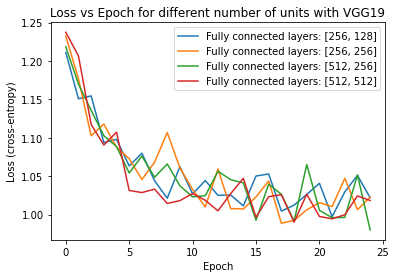

In [ ]:
from google.colab import files

plt.plot(history3.history['val_loss'], label = "Fully connected layers: [256, 128]")

plt.plot(history2[1].history['val_loss'], label = "Fully connected layers: [256, 256]")

plt.plot(history4.history['val_loss'], label = "Fully connected layers: [512, 256]")

plt.plot(history5.history['val_loss'], label = "Fully connected layers: [512, 512]")

plt.title('Loss vs Epoch for different number of units with VGG19')
plt.xlabel('Epoch')
plt.ylabel('Loss (cross-entropy)')
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig('Loss_Epoch with different hidden unit counts.pdf', format='pdf', bbox_inches='tight')
files.download('Loss_Epoch with different hidden unit counts.pdf')
plt.show()

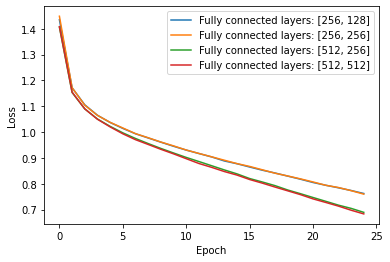

In [ ]:
plt.plot(history3.history['loss'], label = "Fully connected layers: [256, 128]")

plt.plot(history2[1].history['loss'], label = "Fully connected layers: [256, 256]")

plt.plot(history4.history['loss'], label = "Fully connected layers: [512, 256]")

plt.plot(history5.history['loss'], label = "Fully connected layers: [512, 512]")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1, 1))
#test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

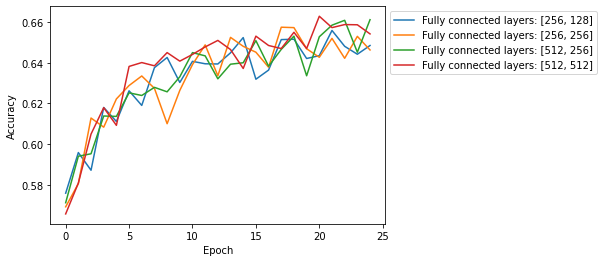

In [ ]:
plt.plot(history3.history['val_accuracy'], label = "Fully connected layers: [256, 128]")

plt.plot(history2[1].history['val_accuracy'], label = "Fully connected layers: [256, 256]")

plt.plot(history4.history['val_accuracy'], label = "Fully connected layers: [512, 256]")

plt.plot(history5.history['val_accuracy'], label = "Fully connected layers: [512, 512]")

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1, 1))

ResNet101:

##Analysis using Pre-trained model

In [ ]:
from tensorflow.keras.applications import ResNet101V2

# Preparing Model
from keras.layers import Dense,Flatten,Input
from keras.models import Sequential

In [ ]:
base_model = ResNet101V2(input_shape=(32,32,3),weights='imagenet',include_top=False,classes=y_train.shape[1])

## Defining model with different number of fully connected layers for comparison

In [ ]:
model2= models.Sequential()
model2.add(base_model)
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(10, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

model2.compile(optimizer=SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model2.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 1, 1, 2048)        42626560  
                                                                 
 flatten_18 (Flatten)        (None, 2048)              0         
                                                                 
 dense_50 (Dense)            (None, 256)               524544    
                                                                 
 dense_51 (Dense)            (None, 10)                2570      
                                                                 
Total params: 43,153,674
Trainable params: 527,114
Non-trainable params: 42,626,560
_________________________________________________________________


In [ ]:
history2 = model2.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_test, y_test))
with open("history_cnn.pkl", 'wb') as file:
    pickle.dump(history2, file)

Epoch 1/25
1563/1563 [==============================] - 39s 21ms/step - loss: 1.9896 - accuracy: 0.3088 - val_loss: 1.8556 - val_accuracy: 0.3600
Epoch 2/25
1563/1563 [==============================] - 31s 20ms/step - loss: 1.7874 - accuracy: 0.3838 - val_loss: 1.7781 - val_accuracy: 0.3805
Epoch 3/25
1563/1563 [==============================] - 30s 19ms/step - loss: 1.7046 - accuracy: 0.4125 - val_loss: 1.7391 - val_accuracy: 0.3926
Epoch 4/25
1563/1563 [==============================] - 30s 19ms/step - loss: 1.6492 - accuracy: 0.4268 - val_loss: 1.7122 - val_accuracy: 0.4019
Epoch 5/25
1563/1563 [==============================] - 30s 19ms/step - loss: 1.6030 - accuracy: 0.4418 - val_loss: 1.6977 - val_accuracy: 0.4053
Epoch 6/25
1563/1563 [==============================] - 30s 19ms/step - loss: 1.5643 - accuracy: 0.4551 - val_loss: 1.6942 - val_accuracy: 0.4057
Epoch 7/25
1563/1563 [==============================] - 30s 19ms/step - loss: 1.5299 - accuracy: 0.4659 - val_loss: 1.6789 -

In [ ]:
model3= models.Sequential()
model3.add(base_model)
model3.add(layers.Flatten())
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dense(10, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

model3.compile(optimizer=SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model3.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 1, 1, 2048)        42626560  
                                                                 
 flatten_11 (Flatten)        (None, 2048)              0         
                                                                 
 dense_30 (Dense)            (None, 256)               524544    
                                                                 
 dense_31 (Dense)            (None, 256)               65792     
                                                                 
 dense_32 (Dense)            (None, 10)                2570      
                                                                 
Total params: 43,219,466
Trainable params: 592,906
Non-trainable params: 42,626,560
_________________________________________________________________


In [ ]:
history3 = model3.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_test, y_test))
with open("history_cnn1.pkl", 'wb') as file:
    pickle.dump(history3, file)

Epoch 1/25
1563/1563 [==============================] - 38s 21ms/step - loss: 2.0289 - accuracy: 0.2914 - val_loss: 1.8703 - val_accuracy: 0.3510
Epoch 2/25
1563/1563 [==============================] - 31s 20ms/step - loss: 1.7959 - accuracy: 0.3754 - val_loss: 1.7817 - val_accuracy: 0.3785
Epoch 3/25
1563/1563 [==============================] - 31s 20ms/step - loss: 1.6994 - accuracy: 0.4054 - val_loss: 1.7368 - val_accuracy: 0.3970
Epoch 4/25
1563/1563 [==============================] - 31s 20ms/step - loss: 1.6322 - accuracy: 0.4275 - val_loss: 1.7152 - val_accuracy: 0.4004
Epoch 5/25
1563/1563 [==============================] - 31s 20ms/step - loss: 1.5761 - accuracy: 0.4451 - val_loss: 1.6877 - val_accuracy: 0.4064
Epoch 6/25
1563/1563 [==============================] - 31s 20ms/step - loss: 1.5279 - accuracy: 0.4642 - val_loss: 1.6806 - val_accuracy: 0.4105
Epoch 7/25
1563/1563 [==============================] - 31s 20ms/step - loss: 1.4822 - accuracy: 0.4772 - val_loss: 1.6766 -

In [ ]:
model4= models.Sequential()
model4.add(base_model)
model4.add(layers.Flatten())
model4.add(layers.Dense(256, activation='relu'))
model4.add(layers.Dense(256, activation='relu'))
model4.add(layers.Dense(256, activation='relu'))
model4.add(layers.Dense(10, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

model4.compile(optimizer=SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model4.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 1, 1, 2048)        42626560  
                                                                 
 flatten_12 (Flatten)        (None, 2048)              0         
                                                                 
 dense_33 (Dense)            (None, 256)               524544    
                                                                 
 dense_34 (Dense)            (None, 256)               65792     
                                                                 
 dense_35 (Dense)            (None, 256)               65792     
                                                                 
 dense_36 (Dense)            (None, 10)                2570      
                                                                 
Total params: 43,285,258
Trainable params: 658,698
No

In [ ]:
history4 = model4.fit(x_train, y_train, epochs=25, batch_size=1000, validation_data=(x_test, y_test))
with open("history_cnn2.pkl", 'wb') as file:
    pickle.dump(history4, file)

Epoch 1/25
50/50 [==============================] - 15s 190ms/step - loss: 2.3036 - accuracy: 0.1187 - val_loss: 2.2829 - val_accuracy: 0.1339
Epoch 2/25
50/50 [==============================] - 8s 153ms/step - loss: 2.2700 - accuracy: 0.1393 - val_loss: 2.2583 - val_accuracy: 0.1554
Epoch 3/25
50/50 [==============================] - 8s 155ms/step - loss: 2.2467 - accuracy: 0.1654 - val_loss: 2.2363 - val_accuracy: 0.1778
Epoch 4/25
50/50 [==============================] - 8s 157ms/step - loss: 2.2244 - accuracy: 0.1878 - val_loss: 2.2147 - val_accuracy: 0.2010
Epoch 5/25
50/50 [==============================] - 8s 159ms/step - loss: 2.2026 - accuracy: 0.2099 - val_loss: 2.1936 - val_accuracy: 0.2202
Epoch 6/25
50/50 [==============================] - 8s 160ms/step - loss: 2.1811 - accuracy: 0.2302 - val_loss: 2.1727 - val_accuracy: 0.2363
Epoch 7/25
50/50 [==============================] - 8s 160ms/step - loss: 2.1599 - accuracy: 0.2462 - val_loss: 2.1520 - val_accuracy: 0.2501
Epoch

## Read trained model histories from files (only for running without retraining)

In [ ]:
file_names=[]
nos=['']
nos.extend(np.arange(1,3))
file_names.append('history_cnn')
history2=[]
for f in nos:
  file = open(file_names[0]+str(f)+'.pkl','rb')
  history2.append(pickle.load(file))
  file.close()

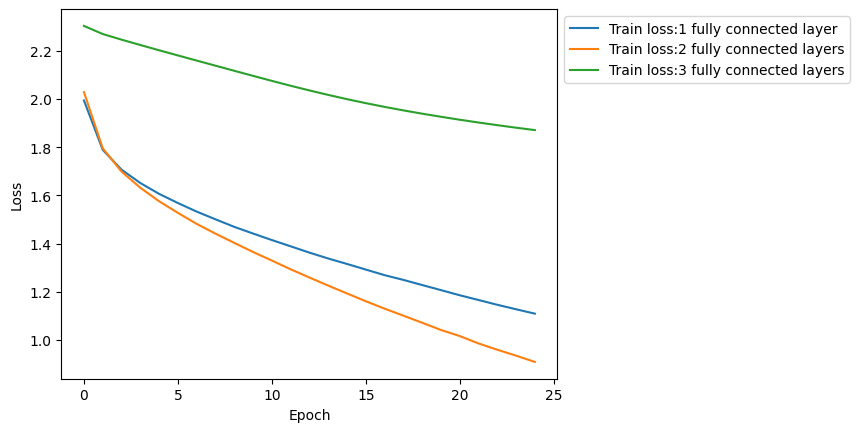

In [ ]:
labels=['1 fully connected layer', '2 fully connected layers', '3 fully connected layers']
for i in range(len(history2)):
  #plt.plot(history2[i].history['val_loss'], label = labels[i])
  plt.plot(history2[i].history['loss'], label = "Train loss:"+labels[i])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1, 1))
#test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

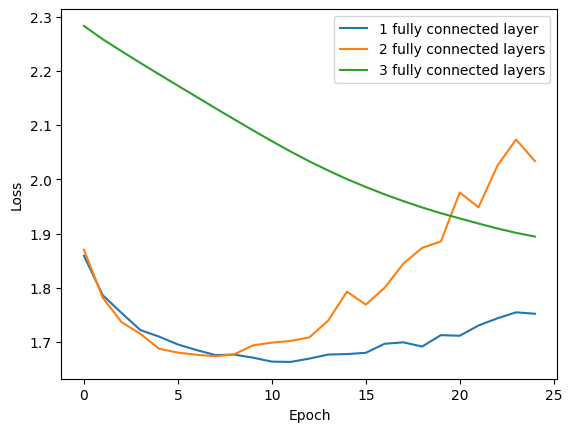

In [ ]:
labels=['1 fully connected layer', '2 fully connected layers','3 fully connected layers']
for i in range(len(history2)):
  plt.plot(history2[i].history['val_loss'], label = labels[i])
  #plt.plot(history[i].history['loss'], label = "Train loss:"+labels[i])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1, 1))
#test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

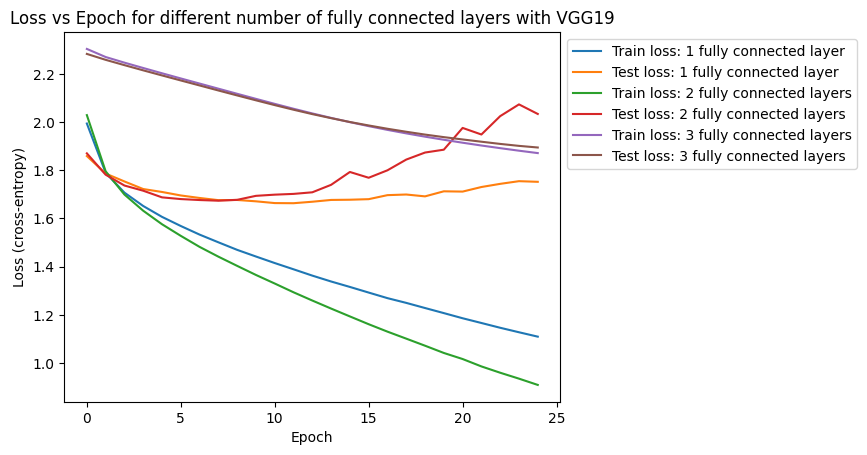

In [ ]:
from google.colab import files


labels=['1 fully connected layer', '2 fully connected layers', '3 fully connected layers']
for i in range(len(history2)):
  plt.plot(history2[i].history['loss'], label = "Train loss: "+labels[i])
  plt.plot(history2[i].history['val_loss'], label = "Test loss: "+labels[i])
plt.title('Loss vs Epoch for different number of fully connected layers with VGG19')
plt.xlabel('Epoch')
plt.ylabel('Loss (cross-entropy)')
plt.legend(bbox_to_anchor=(1, 1))

# plt.savefig('Loss_Epoch different hidden layer count.pdf', format='pdf', bbox_inches='tight')
# files.download('Loss_Epoch different hidden layer count.pdf')
plt.show()

In [ ]:
label=labels[0]
minimum=np.min(history2[0].history['val_loss'])
min_i=0
epoch=history2[0].history['val_loss'].index(minimum)
for i in range(1,len(history2)):
  if np.min(history2[i].history['val_loss'])< minimum:
    label=labels[i]
    minimum=np.min(history2[i].history['val_loss'])
    min_i=i
    epoch=history2[i].history['val_loss'].index(minimum)

print("Minimum loss observed with", label, 'at epoch', epoch+1)
print("Minimum loss is", minimum)
print("Accuracy at this point is", 100*history2[min_i].history['val_accuracy'][epoch], "%")

Minimum loss observed with 1 fully connected layer at epoch 12
Minimum loss is 1.6633939743041992
Accuracy at this point is 42.649999260902405 %


## Defining models with different number of units in the 2 fully connected layers for comparison

In [ ]:
model5= models.Sequential()
model5.add(base_model)
model5.add(layers.Flatten())
model5.add(layers.Dense(256, activation='relu'))
model5.add(layers.Dense(128, activation='relu'))
model5.add(layers.Dense(10, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

model5.compile(optimizer=SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model5.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 1, 1, 2048)        42626560  
                                                                 
 flatten_13 (Flatten)        (None, 2048)              0         
                                                                 
 dense_37 (Dense)            (None, 256)               524544    
                                                                 
 dense_38 (Dense)            (None, 128)               32896     
                                                                 
 dense_39 (Dense)            (None, 10)                1290      
                                                                 
Total params: 43,185,290
Trainable params: 558,730
Non-trainable params: 42,626,560
_________________________________________________________________


In [ ]:
history3 = model5.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_test, y_test))
with open("history_cnn_2layer1.pkl", 'wb') as file:
    pickle.dump(history3, file)

Epoch 1/25
1563/1563 [==============================] - 38s 21ms/step - loss: 2.0206 - accuracy: 0.2899 - val_loss: 1.8696 - val_accuracy: 0.3470
Epoch 2/25
1563/1563 [==============================] - 31s 20ms/step - loss: 1.7885 - accuracy: 0.3768 - val_loss: 1.7769 - val_accuracy: 0.3817
Epoch 3/25
1563/1563 [==============================] - 31s 20ms/step - loss: 1.6926 - accuracy: 0.4079 - val_loss: 1.7330 - val_accuracy: 0.3925
Epoch 4/25
1563/1563 [==============================] - 31s 20ms/step - loss: 1.6245 - accuracy: 0.4301 - val_loss: 1.7039 - val_accuracy: 0.3994
Epoch 5/25
1563/1563 [==============================] - 31s 20ms/step - loss: 1.5690 - accuracy: 0.4489 - val_loss: 1.6923 - val_accuracy: 0.4047
Epoch 6/25
1563/1563 [==============================] - 31s 20ms/step - loss: 1.5210 - accuracy: 0.4634 - val_loss: 1.6797 - val_accuracy: 0.4091
Epoch 7/25
1563/1563 [==============================] - 31s 20ms/step - loss: 1.4762 - accuracy: 0.4797 - val_loss: 1.6705 -

In [ ]:
minimum2=np.min(history3.history['val_loss'])
epoch2=history3.history['val_loss'].index(minimum2)
print("Minimum loss for model is observed at epoch", epoch2+1)
print("Minimum loss is", minimum2)
print("Accuracy at this point is", 100*history3.history['val_accuracy'][epoch2], "%")

Minimum loss for model is observed at epoch 7
Minimum loss is 1.6705400943756104
Accuracy at this point is 41.94000065326691 %


In [ ]:
model6= models.Sequential()
model6.add(base_model)
model6.add(layers.Flatten())
model6.add(layers.Dense(512, activation='relu'))
model6.add(layers.Dense(256, activation='relu'))
model6.add(layers.Dense(10, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

model6.compile(optimizer=SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model6.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 1, 1, 2048)        42626560  
                                                                 
 flatten_14 (Flatten)        (None, 2048)              0         
                                                                 
 dense_40 (Dense)            (None, 512)               1049088   
                                                                 
 dense_41 (Dense)            (None, 256)               131328    
                                                                 
 dense_42 (Dense)            (None, 10)                2570      
                                                                 
Total params: 43,809,546
Trainable params: 1,182,986
Non-trainable params: 42,626,560
_________________________________________________________________


In [ ]:
history4 = model6.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_test, y_test))
with open("history_cnn_2layer2.pkl", 'wb') as file:
    pickle.dump(history4, file)

Epoch 1/25
1563/1563 [==============================] - 39s 21ms/step - loss: 1.9970 - accuracy: 0.3042 - val_loss: 1.8640 - val_accuracy: 0.3548
Epoch 2/25
1563/1563 [==============================] - 31s 20ms/step - loss: 1.7704 - accuracy: 0.3853 - val_loss: 1.7671 - val_accuracy: 0.3864
Epoch 3/25
1563/1563 [==============================] - 31s 20ms/step - loss: 1.6702 - accuracy: 0.4194 - val_loss: 1.7466 - val_accuracy: 0.3908
Epoch 4/25
1563/1563 [==============================] - 31s 20ms/step - loss: 1.5978 - accuracy: 0.4415 - val_loss: 1.7094 - val_accuracy: 0.4029
Epoch 5/25
1563/1563 [==============================] - 31s 20ms/step - loss: 1.5374 - accuracy: 0.4630 - val_loss: 1.6934 - val_accuracy: 0.4035
Epoch 6/25
1563/1563 [==============================] - 31s 20ms/step - loss: 1.4816 - accuracy: 0.4812 - val_loss: 1.6816 - val_accuracy: 0.4107
Epoch 7/25
1563/1563 [==============================] - 31s 20ms/step - loss: 1.4301 - accuracy: 0.4997 - val_loss: 1.6739 -

In [ ]:
minimum3=np.min(history4.history['val_loss'])
epoch3=history4.history['val_loss'].index(minimum3)
print("Minimum loss for model is observed at epoch", epoch3+1)
print("Minimum loss is", minimum3)
print("Accuracy at this point is", 100*history3.history['val_accuracy'][epoch3], "%")

Minimum loss for model is observed at epoch 7
Minimum loss is 1.6739253997802734
Accuracy at this point is 41.94000065326691 %


In [ ]:
model7= models.Sequential()
model7.add(base_model)
model7.add(layers.Flatten())
model7.add(layers.Dense(512, activation='relu'))
model7.add(layers.Dense(512, activation='relu'))
model7.add(layers.Dense(10, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

model7.compile(optimizer=SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model7.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 1, 1, 2048)        42626560  
                                                                 
 flatten_15 (Flatten)        (None, 2048)              0         
                                                                 
 dense_43 (Dense)            (None, 512)               1049088   
                                                                 
 dense_44 (Dense)            (None, 512)               262656    
                                                                 
 dense_45 (Dense)            (None, 10)                5130      
                                                                 
Total params: 43,943,434
Trainable params: 1,316,874
Non-trainable params: 42,626,560
_________________________________________________________________


In [ ]:
history5 = model7.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_test, y_test))
with open("history_cnn_2layer3.pkl", 'wb') as file:
    pickle.dump(history5, file)

Epoch 1/25
1563/1563 [==============================] - 38s 21ms/step - loss: 2.0128 - accuracy: 0.3019 - val_loss: 1.8699 - val_accuracy: 0.3509
Epoch 2/25
1563/1563 [==============================] - 31s 20ms/step - loss: 1.7843 - accuracy: 0.3822 - val_loss: 1.7825 - val_accuracy: 0.3747
Epoch 3/25
1563/1563 [==============================] - 31s 20ms/step - loss: 1.6852 - accuracy: 0.4131 - val_loss: 1.7433 - val_accuracy: 0.3855
Epoch 4/25
1563/1563 [==============================] - 31s 20ms/step - loss: 1.6117 - accuracy: 0.4359 - val_loss: 1.7057 - val_accuracy: 0.4041
Epoch 5/25
1563/1563 [==============================] - 31s 20ms/step - loss: 1.5506 - accuracy: 0.4543 - val_loss: 1.7003 - val_accuracy: 0.4033
Epoch 6/25
1563/1563 [==============================] - 31s 20ms/step - loss: 1.4944 - accuracy: 0.4739 - val_loss: 1.6820 - val_accuracy: 0.4142
Epoch 7/25
1563/1563 [==============================] - 31s 20ms/step - loss: 1.4440 - accuracy: 0.4915 - val_loss: 1.6827 -

In [ ]:
minimum4=np.min(history5.history['val_loss'])
epoch4=history5.history['val_loss'].index(minimum4)
print("Minimum loss for model is observed at epoch", epoch4+1)
print("Minimum loss is", minimum4)
print("Accuracy at this point is", 100*history5.history['val_accuracy'][epoch4], "%")

Minimum loss for model is observed at epoch 8
Minimum loss is 1.675000786781311
Accuracy at this point is 41.839998960494995 %


## Read trained model histories from files (only for running without retraining)

In [ ]:
file = open('history_cnn_2layer1.pkl','rb')
history3=pickle.load(file)
file.close()

file = open('history_cnn_2layer2.pkl','rb')
history4=pickle.load(file)
file.close()

file = open('history_cnn_2layer3.pkl','rb')
history5=pickle.load(file)
file.close()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

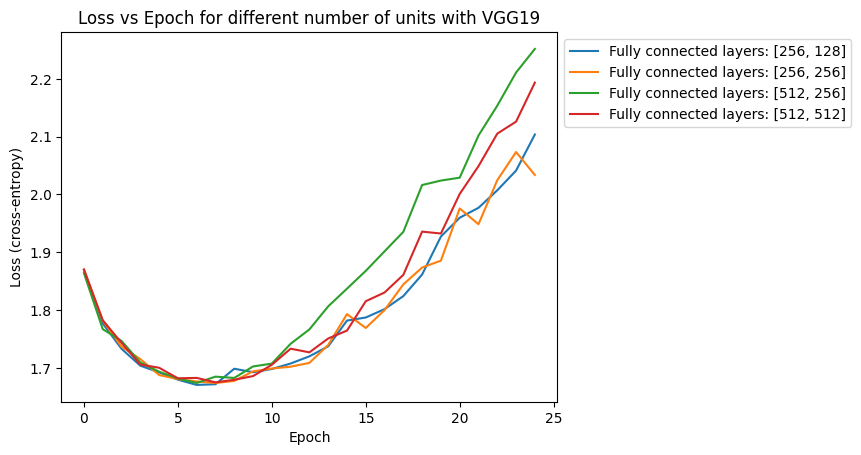

In [ ]:
from google.colab import files

plt.plot(history3.history['val_loss'], label = "Fully connected layers: [256, 128]")

plt.plot(history2[1].history['val_loss'], label = "Fully connected layers: [256, 256]")

plt.plot(history4.history['val_loss'], label = "Fully connected layers: [512, 256]")

plt.plot(history5.history['val_loss'], label = "Fully connected layers: [512, 512]")

plt.title('Loss vs Epoch for different number of units with VGG19')
plt.xlabel('Epoch')
plt.ylabel('Loss (cross-entropy)')
plt.legend(bbox_to_anchor=(1, 1))
# plt.savefig('Loss_Epoch with different hidden unit counts.pdf', format='pdf', bbox_inches='tight')
# files.download('Loss_Epoch with different hidden unit counts.pdf')
plt.show()

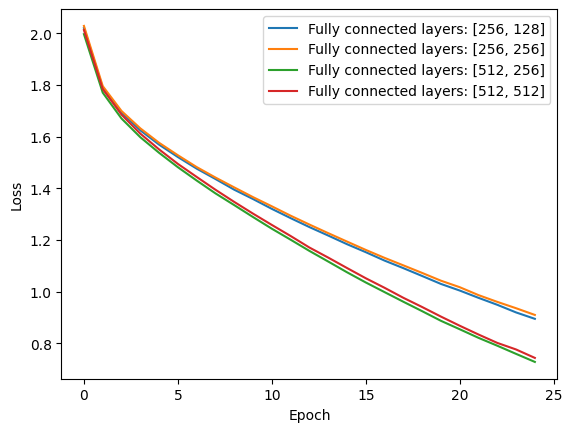

In [ ]:
plt.plot(history3.history['loss'], label = "Fully connected layers: [256, 128]")

plt.plot(history2[1].history['loss'], label = "Fully connected layers: [256, 256]")

plt.plot(history4.history['loss'], label = "Fully connected layers: [512, 256]")

plt.plot(history5.history['loss'], label = "Fully connected layers: [512, 512]")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1, 1))
#test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

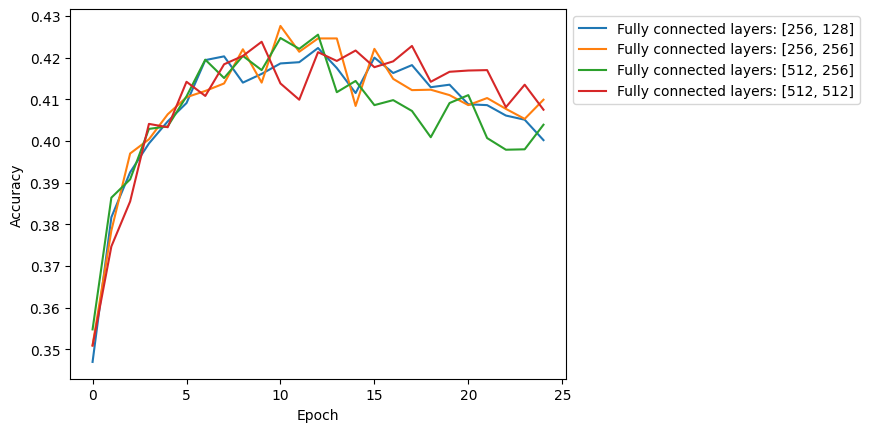

In [ ]:
plt.plot(history3.history['val_accuracy'], label = "Fully connected layers: [256, 128]")

plt.plot(history2[1].history['val_accuracy'], label = "Fully connected layers: [256, 256]")

plt.plot(history4.history['val_accuracy'], label = "Fully connected layers: [512, 256]")

plt.plot(history5.history['val_accuracy'], label = "Fully connected layers: [512, 512]")

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1, 1))

#Another dataset:

Download to Drive:

In [ ]:
# from google.colab import files
# files.upload()

In [ ]:
# !rm -r ~/.kaggle
# !mkdir ~/.kaggle
# !mv ./kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !kaggle datasets download -d positivepc/object-detection

In [ ]:
from google.colab import drive
import os

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/My Drive/Datasets")

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os

In [ ]:
eb_train_data = 'Training_set/Training_set/electric bus/'
ec_train_data = 'Training_set/Training_set/electric car/'
eb_test_data = 'test/test/electric bus/'
ec_test_data = 'test/test/electric car/'
train_data = 'Training_set/Training_set/'
test_data = 'test/test/'

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_data, target_size=(224,224), classes=['electric bus', 'electric car'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_data, target_size=(224,224), classes=['electric bus', 'electric car'], batch_size=10)

Found 1486 images belonging to 2 classes.
Found 382 images belonging to 2 classes.


In [ ]:
X_train, y_train = next(train_batches)
X_test, y_test = next(test_batches)

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

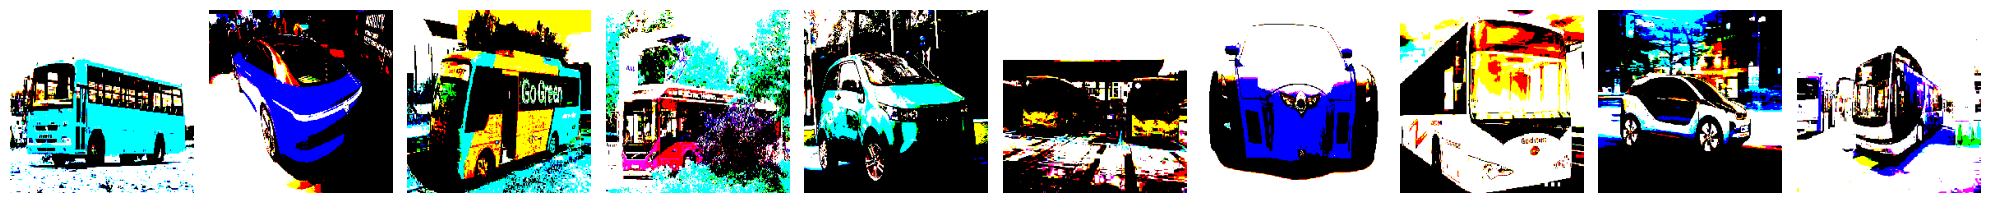

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [ ]:
plotImages(X_test)
print(y_test)

In [ ]:
processed_train_data = tf.keras.utils.image_dataset_from_directory(train_data)
processed_test_data = tf.keras.utils.image_dataset_from_directory(test_data)
processed_train_data

Found 1486 files belonging to 2 classes.
Found 382 files belonging to 2 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

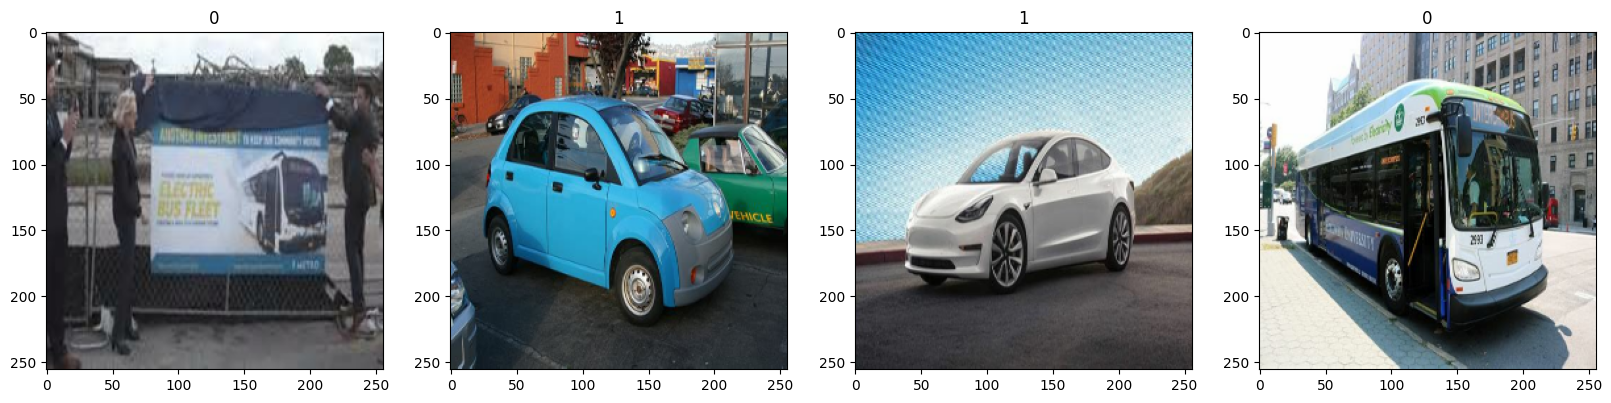

In [ ]:
# from google.colab import files
batch = processed_train_data.as_numpy_iterator().next()
# train_data_batch = data_iterator
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# plt.savefig('dataset.pdf', format='pdf', bbox_inches='tight')
# files.download('dataset.pdf')
# plt.show()

In [ ]:
len(batch)
processed_train_data.as_numpy_iterator().next()
processed_train_data??

In [ ]:
processed_train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
import PIL
from PIL import Image

In [ ]:
train_arr =  []
for i in os.listdir(train_data):
    arr = []
    for j in os.listdir(os.path.join(train_data, i)):
        img= Image.open(os.path.join(train_data, i, j))
        np_img = np.array(img)
        train_arr.append(np_img)
#     train_arr.append(arr)
np_train_arr = np.array(train_arr)
np_train_arr.shape

<ipython-input-17-15535c90e121>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np_train_arr = np.array(train_arr)


(1486,)

In [ ]:
np_train_label_arr = np.array([0 if i<743 else 1 for i in range(1486)])
# np_train_label_arr.unique()
print(np.unique(np_train_label_arr))

[0 1]


In [ ]:
test_arr =  []
for i in os.listdir(test_data):
    arr = []
    for j in os.listdir(os.path.join(test_data, i)):
        img= Image.open(os.path.join(test_data, i, j))
        np_img = np.array(img)
        test_arr.append(np_img)
#     test_arr.append(arr)
np_test_arr = np.array(test_arr)
np_test_arr.shape

<ipython-input-19-0823be39e380>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np_test_arr = np.array(test_arr)


(382,)

In [ ]:
np_test_label_arr = np.array([0 if i<191 else 1 for i in range(382)])
print(np.unique(np_test_label_arr))

[0 1]


In [ ]:
np_train_arr[0].shape
# train_df = pd.DataFrame(np_train_arr)

(355, 474, 3)

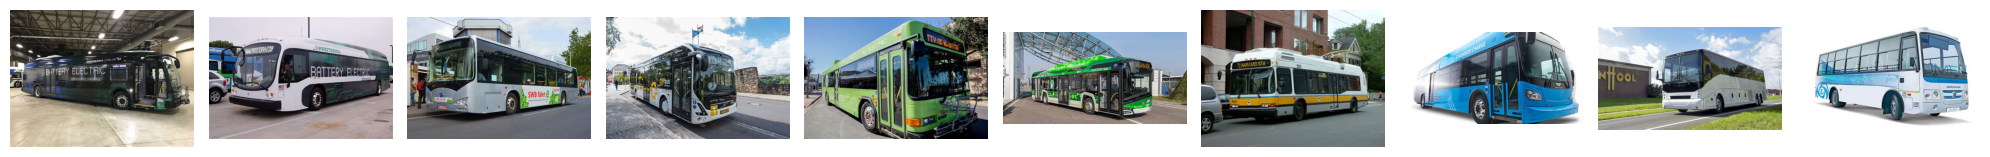

In [ ]:
plotImages(np_train_arr)

In [ ]:
size = (255, 255)
def image_resize(arr):
    arr = [tf.keras.preprocessing.image.smart_resize(
        item, size, interpolation='bilinear'
        ) for item in arr]
    return arr

In [ ]:
np_train_arr = image_resize(np_train_arr/255)
np_test_arr = image_resize(np_test_arr/255)

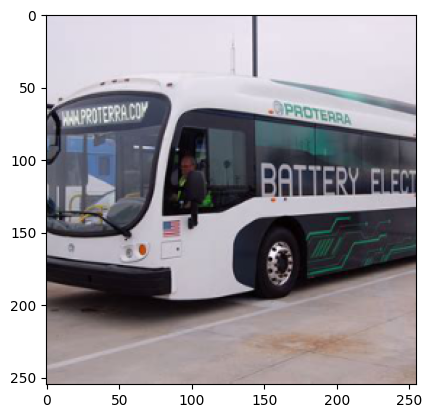

In [ ]:
np_train_arr[1].shape
np_train_arr[1]
plt.imshow(np_train_arr[1])

In [ ]:
np_train_arr = np.reshape(np_train_arr, (1486, 255, 255, 3))
np_train_label_arr = np.reshape(np_train_label_arr, (1486,))
np_test_arr = np.reshape(np_train_arr, (1486, 255, 255, 3))
np_test_label_arr = np.reshape(np_train_label_arr, (1486,))
print(len(np_train_arr))
print(len(np_train_label_arr))
print(np_train_arr.shape)
print(np_train_label_arr.shape)

1486
1486
(1486, 255, 255, 3)
(1486,)


In [ ]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(np_train_arr, np_train_label_arr)
X_test, y_test = shuffle(np_test_arr, np_test_label_arr)

1


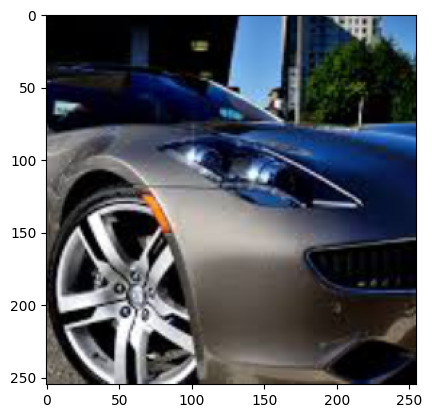

In [ ]:
X_train[3].shape
X_train[3]
plt.imshow(X_train[3])
print(y_train[3])

(255, 255, 3)
0


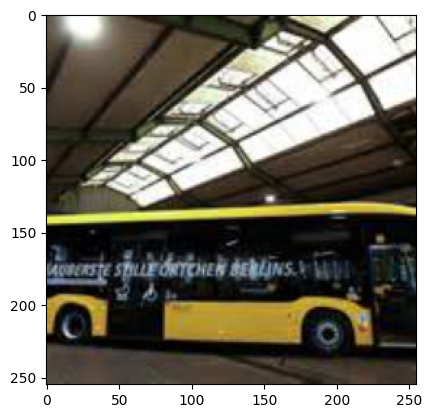

In [ ]:
print(X_train[2].shape)
X_train[2]
plt.imshow(X_train[2])
print(y_train[2])

In [ ]:
y_train.shape

(1486,)

MLP:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import files
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')
import math
import sys
from tensorflow.keras import regularizers

In [ ]:
from keras.utils.np_utils import to_categorical

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pickle

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import SGD

In [ ]:
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [ ]:
model1= models.Sequential()
model1.add(layers.Flatten(input_shape = [255,255,3]))
model1.add(layers.Dense(256, kernel_regularizer='l2', activation='relu'))
model1.add(layers.Dense(256, kernel_regularizer='l2', activation='relu'))
model1.add(layers.Dense(2, activation='softmax'))

model1.compile(optimizer=SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 195075)            0         
                                                                 
 dense_3 (Dense)             (None, 256)               49939456  
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 2)                 514       
                                                                 
Total params: 50,005,762
Trainable params: 50,005,762
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history1 = model1.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/100
12/12 [==============================] - 4s 278ms/step - loss: 11.9879 - accuracy: 0.5027 - val_loss: 8.3014 - val_accuracy: 0.6575
Epoch 2/100
12/12 [==============================] - 1s 97ms/step - loss: 8.3003 - accuracy: 0.6063 - val_loss: 8.2348 - val_accuracy: 0.6965
Epoch 3/100
12/12 [==============================] - 1s 97ms/step - loss: 8.2363 - accuracy: 0.6480 - val_loss: 8.1326 - val_accuracy: 0.7362
Epoch 4/100
12/12 [==============================] - 1s 95ms/step - loss: 8.1996 - accuracy: 0.6561 - val_loss: 8.1462 - val_accuracy: 0.7261
Epoch 5/100
12/12 [==============================] - 1s 93ms/step - loss: 8.1146 - accuracy: 0.6972 - val_loss: 8.0217 - val_accuracy: 0.7342
Epoch 6/100
12/12 [==============================] - 1s 100ms/step - loss: 8.0776 - accuracy: 0.6958 - val_loss: 8.0130 - val_accuracy: 0.7174
Epoch 7/100
12/12 [==============================] - 1s 101ms/step - loss: 8.0050 - accuracy: 0.7106 - val_loss: 7.9374 - val_accuracy: 0.7503
Ep

CNN:

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pickle

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import SGD

In [ ]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dropout(0.4))
model2.add(layers.Dense(2, activation='softmax'))
model2.summary()

W_init = model2.get_weights()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 253, 253, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 126, 126, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 246016)            0         
                                                                 
 dense_9 (Dense)             (None, 256)              

In [ ]:
model2.set_weights(W_init)
model2.compile(optimizer=SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model2.fit(X_train, y_train, epochs=35, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/35
47/47 [==============================] - 13s 127ms/step - loss: 0.6369 - accuracy: 0.6400 - val_loss: 0.5387 - val_accuracy: 0.7638
Epoch 2/35
47/47 [==============================] - 4s 77ms/step - loss: 0.5468 - accuracy: 0.7355 - val_loss: 0.5276 - val_accuracy: 0.7322
Epoch 3/35
47/47 [==============================] - 4s 76ms/step - loss: 0.4869 - accuracy: 0.7712 - val_loss: 0.4886 - val_accuracy: 0.7712
Epoch 4/35
47/47 [==============================] - 4s 77ms/step - loss: 0.4643 - accuracy: 0.7981 - val_loss: 0.4363 - val_accuracy: 0.8331
Epoch 5/35
47/47 [==============================] - 4s 77ms/step - loss: 0.4352 - accuracy: 0.8082 - val_loss: 0.4211 - val_accuracy: 0.8392
Epoch 6/35
47/47 [==============================] - 4s 77ms/step - loss: 0.4087 - accuracy: 0.8271 - val_loss: 0.4498 - val_accuracy: 0.8102
Epoch 7/35
47/47 [==============================] - 4s 77ms/step - loss: 0.4029 - accuracy: 0.8338 - val_loss: 0.3452 - val_accuracy: 0.8654
Epoch 8/35


VGG19:

##Analysis using Pre-trained model

In [ ]:
# VGG19 Model
from keras.applications.vgg19 import VGG19

# Preparing VGG19 Model
from keras.layers import Dense,Flatten,Input
from keras.models import Sequential

In [ ]:
base_model = VGG19(include_top=False,weights='imagenet',input_shape=X_train.shape[1:],classes=y_train.shape[1])

In [ ]:
model3= models.Sequential()
model3.add(base_model)
model3.add(layers.Flatten())
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dropout(0.4))
model3.add(layers.Dense(2, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

model3.compile(optimizer=SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_5 (Flatten)         (None, 25088)             0         
                                                                 
 dense_15 (Dense)            (None, 256)               6422784   
                                                                 
 dense_16 (Dense)            (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 2)                 514       
                                                                 
Total params: 26,513,474
Trainable params: 6,489,090
N

In [ ]:
history3 = model3.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/40
47/47 [==============================] - 31s 642ms/step - loss: 0.7684 - accuracy: 0.6036 - val_loss: 0.6623 - val_accuracy: 0.5000
Epoch 2/40
47/47 [==============================] - 28s 606ms/step - loss: 0.5654 - accuracy: 0.7268 - val_loss: 0.4160 - val_accuracy: 0.7786
Epoch 3/40
47/47 [==============================] - 27s 579ms/step - loss: 0.4094 - accuracy: 0.8122 - val_loss: 0.3383 - val_accuracy: 0.9637
Epoch 4/40
47/47 [==============================] - 27s 587ms/step - loss: 0.2416 - accuracy: 0.9139 - val_loss: 0.2977 - val_accuracy: 0.8526
Epoch 5/40
47/47 [==============================] - 34s 739ms/step - loss: 0.1676 - accuracy: 0.9381 - val_loss: 0.1329 - val_accuracy: 0.9522
Epoch 6/40
47/47 [==============================] - 27s 590ms/step - loss: 0.1069 - accuracy: 0.9657 - val_loss: 0.0750 - val_accuracy: 0.9791
Epoch 7/40
47/47 [==============================] - 28s 596ms/step - loss: 0.1921 - accuracy: 0.9421 - val_loss: 0.0721 - val_accuracy: 0.9798

ResNet101:

In [ ]:
from tensorflow.keras.applications import ResNet101V2

# Preparing Model
from keras.layers import Dense,Flatten,Input
from keras.models import Sequential

In [ ]:
base_model = ResNet101V2(input_shape=X_train.shape[1:],weights='imagenet',include_top=False,classes=y_train.shape[1])

171317808/171317808 [==============================] - 1s 0us/step


In [ ]:
model3= models.Sequential()
model3.add(base_model)
model3.add(layers.Flatten())
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dense(2, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

model3.compile(optimizer=SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 8, 8, 2048)        42626560  
                                                                 
 flatten_2 (Flatten)         (None, 131072)            0         
                                                                 
 dense_6 (Dense)             (None, 256)               33554688  
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dense_8 (Dense)             (None, 2)                 514       
                                                                 
Total params: 76,247,554
Trainable params: 33,620,994
Non-trainable params: 42,626,560
_________________________________________________________________


In [ ]:
history3 = model3.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/25
47/47 [==============================] - 29s 453ms/step - loss: 0.3925 - accuracy: 0.9616 - val_loss: 0.0122 - val_accuracy: 0.9966
Epoch 2/25
47/47 [==============================] - 16s 353ms/step - loss: 0.0054 - accuracy: 0.9980 - val_loss: 0.0063 - val_accuracy: 0.9966
Epoch 3/25
47/47 [==============================] - 16s 353ms/step - loss: 7.2803e-04 - accuracy: 1.0000 - val_loss: 1.6334e-04 - val_accuracy: 1.0000
Epoch 4/25
47/47 [==============================] - 17s 355ms/step - loss: 1.2778e-04 - accuracy: 1.0000 - val_loss: 4.5158e-05 - val_accuracy: 1.0000
Epoch 5/25
47/47 [==============================] - 17s 357ms/step - loss: 4.4168e-05 - accuracy: 1.0000 - val_loss: 3.6653e-05 - val_accuracy: 1.0000
Epoch 6/25
47/47 [==============================] - 17s 358ms/step - loss: 3.6310e-05 - accuracy: 1.0000 - val_loss: 3.1661e-05 - val_accuracy: 1.0000
Epoch 7/25
47/47 [==============================] - 17s 358ms/step - loss: 3.1468e-05 - accuracy: 1.0000 - val

#Third Dataset:

In [ ]:
from google.colab import drive
import os

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir("/content/drive/My Drive/Datasets/Classifier_dataset")

In [ ]:
#Generic Packages
import numpy as np
import os
import pandas as pd
import random

#Machine Learning Library
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

#Plotting Libraries
import seaborn as sn; sn.set(font_scale=1.4)
import matplotlib.pyplot as plt

#openCV
import cv2

#Tensor Flow
import tensorflow as tf

#Display Progress
from tqdm import tqdm

#Garbage Collector
import gc

In [ ]:
class_names = ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [ ]:
#Function to Load Images & Labels
def load_data():

    datasets = ['_train', '_test']
    output = []

    # Iterate through training and test sets
    for dataset in datasets:

        images = []
        labels = []

        print("Loading {}".format(dataset))

        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')

        output.append((images, labels))

    return output

In [ ]:
#Loading Data (Training & Test Dataset)
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading _train


100%|██████████| 838/838 [00:02<00:00, 312.40it/s]


Loading _test


100%|██████████| 148/148 [00:00<00:00, 328.55it/s]


In [ ]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [ ]:
#Label Dataset Shape
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 5945
Number of testing examples: 940
Each image is of size: (150, 150)


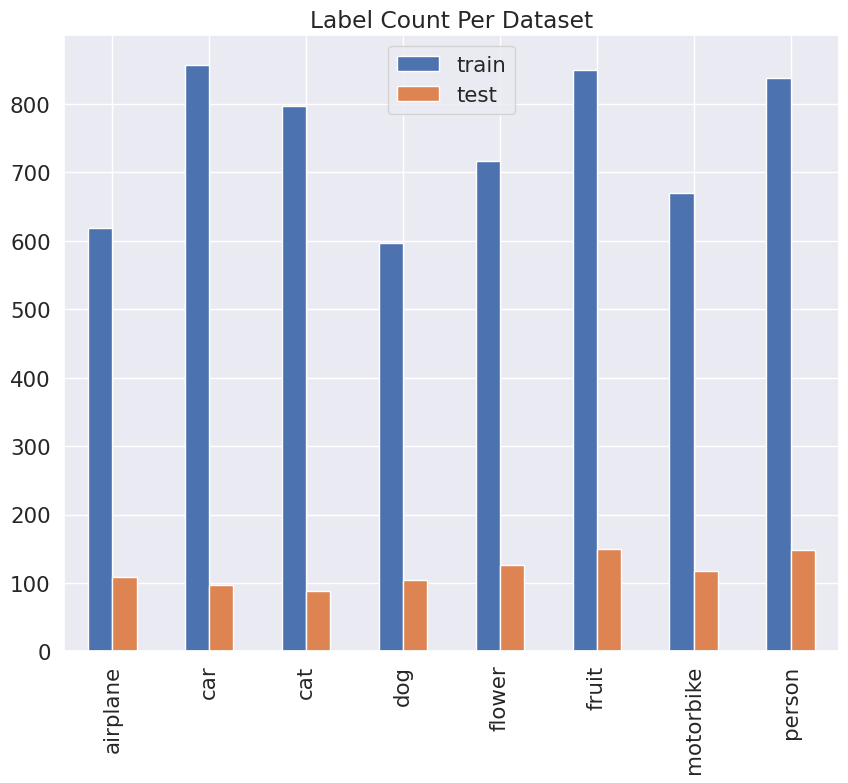

In [ ]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,'test': test_counts}, index=class_names).plot.bar(figsize=(10,8))
plt.title('Label Count Per Dataset')
plt.show()

In [ ]:
#Scale the data
train_images = train_images / 255.0
test_images = test_images / 255.0

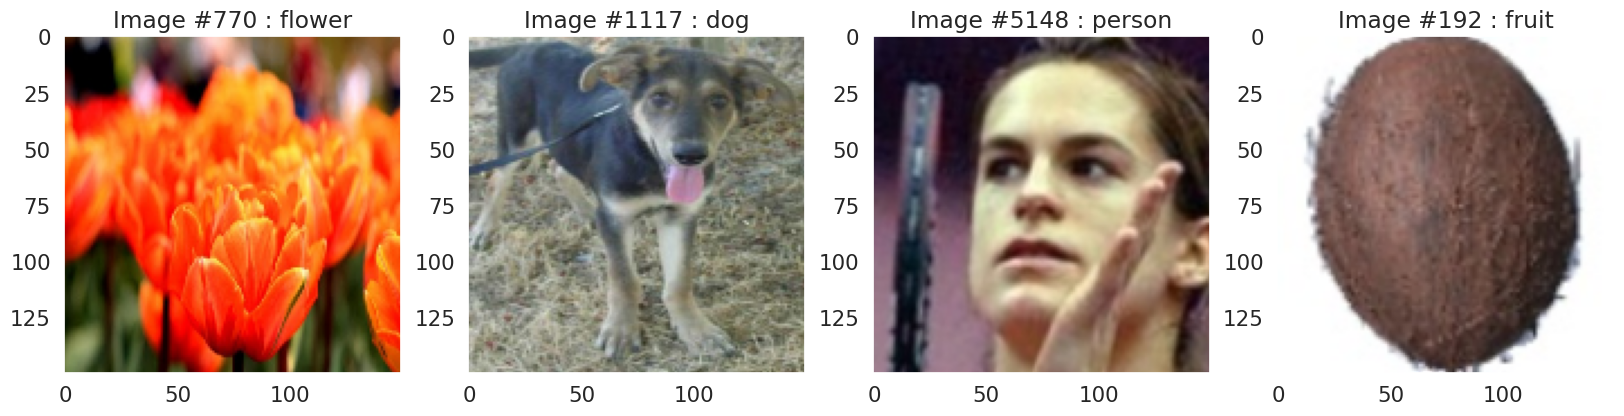

In [ ]:
#Visualise the data [random image from training dataset]

def display_random_img(class_names, images, labels):
  fig, ax = plt.subplots(ncols=4, figsize=(20,20))
  for idx in range(4):
    index = np.random.randint(images.shape[0])
    ax[idx].imshow(images[index])
    ax[idx].title.set_text('Image #{} : '.format(index) + class_names[labels[index]])
    ax[idx].grid(False)

  # plt.savefig('dataset.pdf', format='pdf', bbox_inches='tight')
  # files.download('dataset.pdf')
  plt.show()


display_random_img (class_names, train_images, train_labels)

In [ ]:
X_train = train_images
y_train = train_labels
X_test  = test_images
y_test  = test_labels

In [ ]:
y_test.shape

(940,)

In [ ]:
y_train.shape

In [ ]:
X_train.shape[1:]

(150, 150, 3)

MLP:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import files
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')
import math
import sys

In [ ]:
from keras.utils.np_utils import to_categorical

In [ ]:
y_train = to_categorical(y_train, num_classes=8)
y_test = to_categorical(y_test, num_classes=8)

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pickle

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers

In [ ]:
model1= models.Sequential()
model1.add(layers.Flatten(input_shape = X_train.shape[1:]))
model1.add(layers.Dense(256, kernel_regularizer='l2', activation='relu'))
model1.add(layers.Dense(256, kernel_regularizer='l2', activation='relu'))
model1.add(layers.Dense(8, activation='softmax'))

model1.compile(optimizer=SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 67500)             0         
                                                                 
 dense (Dense)               (None, 256)               17280256  
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 17,348,104
Trainable params: 17,348,104
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history1 = model1.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/100
47/47 [==============================] - 4s 37ms/step - loss: 9.4661 - accuracy: 0.3362 - val_loss: 8.9266 - val_accuracy: 0.5000
Epoch 2/100
47/47 [==============================] - 1s 23ms/step - loss: 8.7159 - accuracy: 0.5563 - val_loss: 8.7220 - val_accuracy: 0.5181
Epoch 3/100
47/47 [==============================] - 1s 25ms/step - loss: 8.4049 - accuracy: 0.6141 - val_loss: 8.2087 - val_accuracy: 0.6787
Epoch 4/100
47/47 [==============================] - 1s 24ms/step - loss: 8.1154 - accuracy: 0.6749 - val_loss: 8.3459 - val_accuracy: 0.6000
Epoch 5/100
47/47 [==============================] - 1s 23ms/step - loss: 7.9580 - accuracy: 0.6844 - val_loss: 7.8796 - val_accuracy: 0.6947
Epoch 6/100
47/47 [==============================] - 1s 23ms/step - loss: 7.7655 - accuracy: 0.6972 - val_loss: 7.6988 - val_accuracy: 0.7106
Epoch 7/100
47/47 [==============================] - 1s 22ms/step - loss: 7.5520 - accuracy: 0.7299 - val_loss: 7.5093 - val_accuracy: 0.7117
Epoch 

CNN:

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pickle

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import SGD

In [ ]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dropout(0.4))
model2.add(layers.Dense(8, activation='softmax'))
model2.summary()

W_init = model2.get_weights()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 82944)             0         
                                                                 
 dense_6 (Dense)             (None, 256)              

In [ ]:
model2.set_weights(W_init)
model2.compile(optimizer=SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history2 = model2.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
186/186 [==============================] - 6s 27ms/step - loss: 1.4584 - accuracy: 0.4807 - val_loss: 0.9255 - val_accuracy: 0.6979
Epoch 2/50
186/186 [==============================] - 4s 24ms/step - loss: 0.8969 - accuracy: 0.6927 - val_loss: 0.6607 - val_accuracy: 0.7596
Epoch 3/50
186/186 [==============================] - 4s 23ms/step - loss: 0.6608 - accuracy: 0.7659 - val_loss: 0.5269 - val_accuracy: 0.8011
Epoch 4/50
186/186 [==============================] - 4s 23ms/step - loss: 0.5169 - accuracy: 0.8145 - val_loss: 0.3867 - val_accuracy: 0.8574
Epoch 5/50
186/186 [==============================] - 4s 24ms/step - loss: 0.4220 - accuracy: 0.8454 - val_loss: 0.3376 - val_accuracy: 0.8606
Epoch 6/50
186/186 [==============================] - 4s 23ms/step - loss: 0.3629 - accuracy: 0.8686 - val_loss: 0.2857 - val_accuracy: 0.8851
Epoch 7/50
186/186 [==============================] - 4s 23ms/step - loss: 0.2995 - accuracy: 0.8922 - val_loss: 0.2495 - val_accuracy: 0.9128

VGG19:

##Analysis using Pre-trained model

In [ ]:
# VGG19 Model
from keras.applications.vgg19 import VGG19

# Preparing VGG19 Model
from keras.layers import Dense,Flatten,Input
from keras.models import Sequential

In [ ]:
base_model = VGG19(include_top=False,weights='imagenet',input_shape=X_train.shape[1:],classes=y_train.shape[1])

In [ ]:
model3= models.Sequential()
model3.add(base_model)
model3.add(layers.Flatten())
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dropout(0.4))
model3.add(layers.Dense(8, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

model3.compile(optimizer=SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_9 (Dense)             (None, 256)               2097408   
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 8)                 2056      
                                                                 
Total params: 22,189,640
Trainable params: 2,165,256
N

In [ ]:
history3 = model3.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/25
186/186 [==============================] - 26s 120ms/step - loss: 0.7644 - accuracy: 0.7536 - val_loss: 0.2584 - val_accuracy: 0.9223
Epoch 2/25
186/186 [==============================] - 20s 105ms/step - loss: 0.2333 - accuracy: 0.9270 - val_loss: 0.1608 - val_accuracy: 0.9426
Epoch 3/25
186/186 [==============================] - 19s 100ms/step - loss: 0.1739 - accuracy: 0.9420 - val_loss: 0.1533 - val_accuracy: 0.9468
Epoch 4/25
186/186 [==============================] - 18s 98ms/step - loss: 0.1376 - accuracy: 0.9524 - val_loss: 0.1094 - val_accuracy: 0.9564
Epoch 5/25
186/186 [==============================] - 18s 99ms/step - loss: 0.1067 - accuracy: 0.9648 - val_loss: 0.0885 - val_accuracy: 0.9617
Epoch 6/25
186/186 [==============================] - 19s 101ms/step - loss: 0.0975 - accuracy: 0.9653 - val_loss: 0.0859 - val_accuracy: 0.9681
Epoch 7/25
186/186 [==============================] - 19s 101ms/step - loss: 0.0902 - accuracy: 0.9716 - val_loss: 0.0875 - val_accu

#Plot Confusion Matrix of Three models:

In [ ]:
scratch_pred_classes = model1.predict(X_test).round()

30/30 [==============================] - 0s 5ms/step


In [ ]:
cnn_pred_classes = model2.predict(X_test).round()

30/30 [==============================] - 0s 8ms/step


In [ ]:
vgg_pred_classes = model3.predict(X_test).round()

30/30 [==============================] - 3s 87ms/step


In [ ]:
true_classes = y_test

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

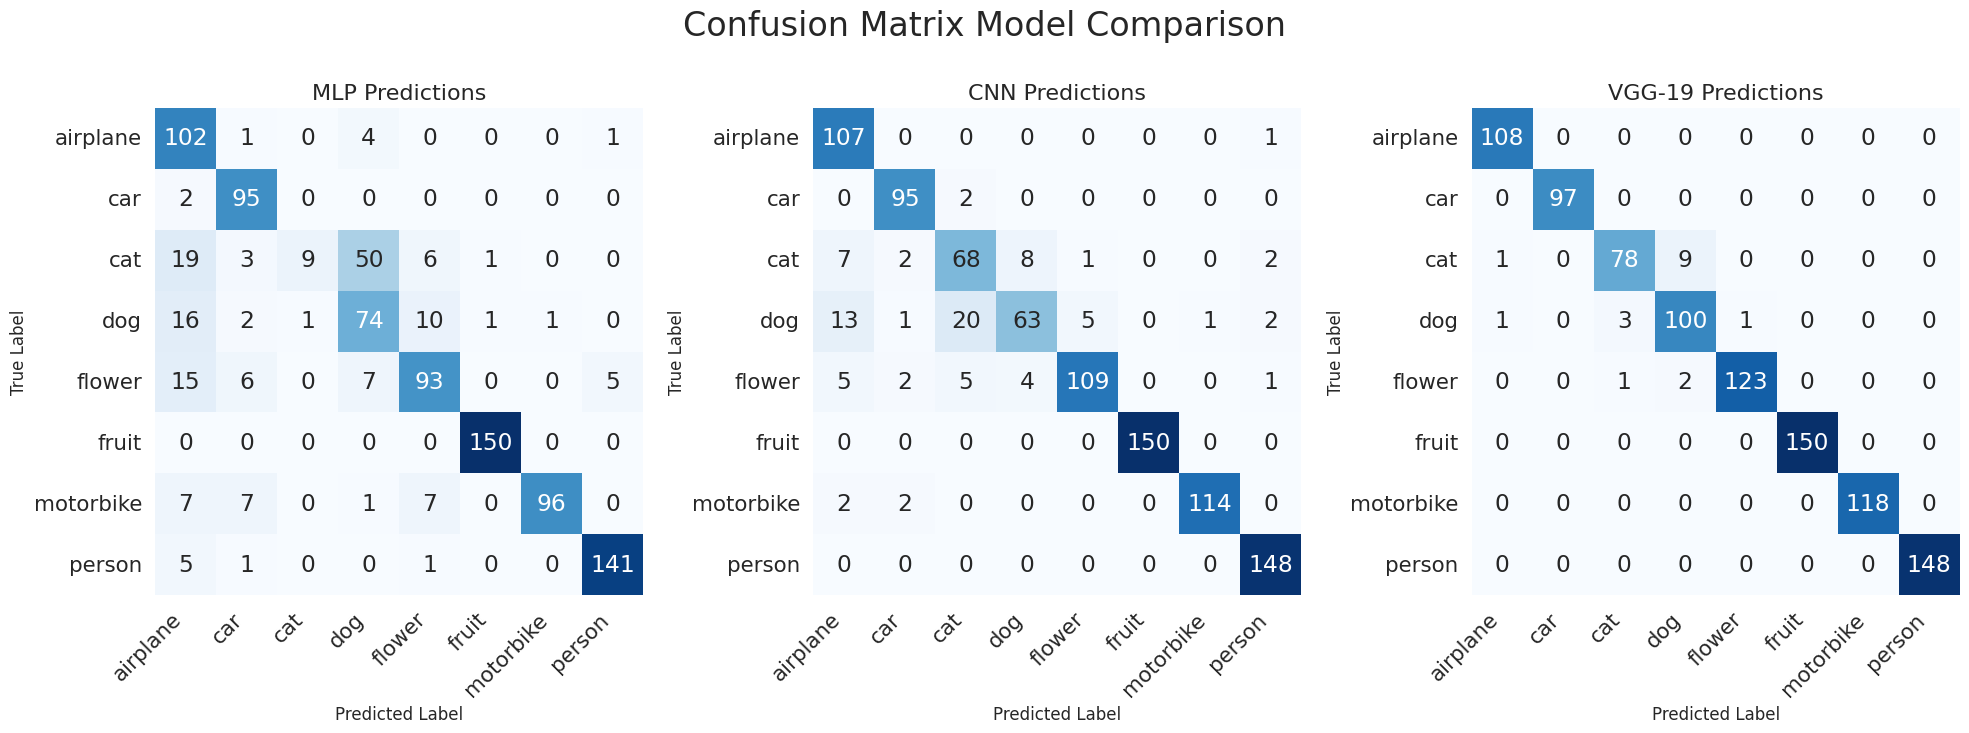

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = class_names

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    sns.heatmap(
        cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

plot_heatmap(true_classes, scratch_pred_classes, class_names, ax1, title="MLP Predictions")
plot_heatmap(true_classes, cnn_pred_classes, class_names, ax2, title="CNN Predictions")
plot_heatmap(true_classes, vgg_pred_classes, class_names, ax3, title="VGG-19 Predictions")

fig.suptitle("Confusion Matrix Model Comparison", fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
# plt.savefig('Confusion_Matrix.pdf', format='pdf', bbox_inches='tight')
# files.download('Confusion_Matrix.pdf')
plt.show()

ResNet101:

In [ ]:
from tensorflow.keras.applications import ResNet101V2

# Preparing Model
from keras.layers import Dense,Flatten,Input
from keras.models import Sequential

In [ ]:
base_model = ResNet101V2(input_shape=X_train.shape[1:],weights='imagenet',include_top=False,classes=y_train.shape[1])

171317808/171317808 [==============================] - 1s 0us/step


In [ ]:
model3= models.Sequential()
model3.add(base_model)
model3.add(layers.Flatten())
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dense(8, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

model3.compile(optimizer=SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 5, 5, 2048)        42626560  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               13107456  
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 55,801,864
Trainable params: 13,175,304
Non-trainable params: 42,626,560
_________________________________________________________________


In [ ]:
history3 = model3.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/25
186/186 [==============================] - 38s 117ms/step - loss: 0.0903 - accuracy: 0.9795 - val_loss: 0.0150 - val_accuracy: 0.9957
Epoch 2/25
186/186 [==============================] - 19s 100ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.0056 - val_accuracy: 0.9979
Epoch 3/25
186/186 [==============================] - 19s 102ms/step - loss: 6.9766e-04 - accuracy: 0.9998 - val_loss: 0.1234 - val_accuracy: 0.9840
Epoch 4/25
186/186 [==============================] - 22s 118ms/step - loss: 7.3587e-04 - accuracy: 0.9997 - val_loss: 0.0090 - val_accuracy: 0.9968
Epoch 5/25
186/186 [==============================] - 22s 120ms/step - loss: 1.0511e-04 - accuracy: 1.0000 - val_loss: 0.0081 - val_accuracy: 0.9968
Epoch 6/25
186/186 [==============================] - 19s 104ms/step - loss: 8.5673e-05 - accuracy: 1.0000 - val_loss: 0.0077 - val_accuracy: 0.9968
Epoch 7/25
186/186 [==============================] - 22s 118ms/step - loss: 7.3677e-05 - accuracy: 1.0000 - val_l